# Single photon analysis Scratch pad - Readout every excitation cycle
Analysis for our first search for photons emitted following an excitation pulse, through $g^{(2)}$ in the future

In [316]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration

# 2025-01-07 & 08

In [345]:
fnames = get_files_by_criteria(date_filters=["2025-01-07", "2025-01-08"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-08\00\000021394-GeneralVariableScan.h5, which is corrupt
skipping C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-08\09\000021408-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_gate_start_offset_mu.h5, which is corrupt
found 54 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-07\02\000021347-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-07\02\000021347-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-07\08\000021350-GeneralVariableScan.h5) scanned over set_point_excitation
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-07\09\000021351-GeneralVariableScan.h5) scanned over set_point_excitation
file 4 (C:\Networking Expe

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'n_excitation_cycles':200, 'gate_start_offset_mu': 700}
# of iterations:  10
n_measurements:  100
n_excitation_cycles:  200


C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


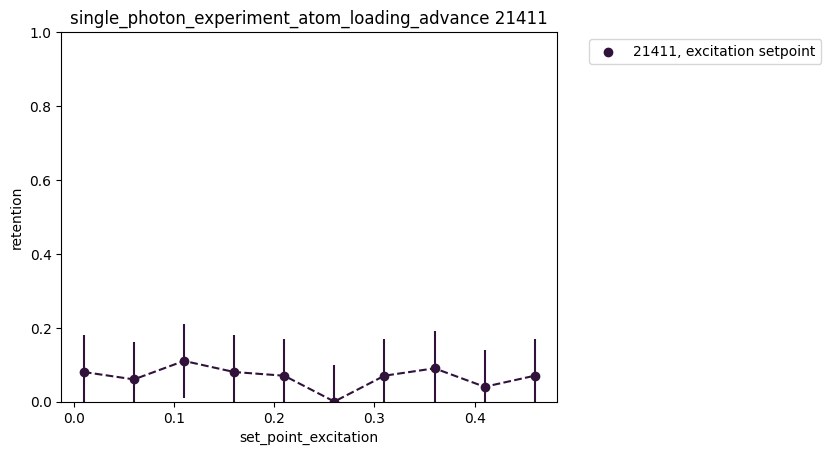

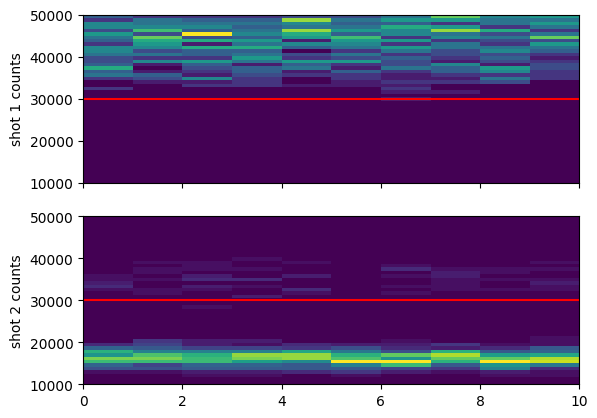

In [252]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = False

show_photocount_hist = True 
calculate_g2 = False


### the files to analyze:
file_indices = {
    48: 'excitation setpoint'
}  


### for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

### for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    print("n_measurements: ", n_measurements)
    print("n_excitation_cycles: ", n_excitation_cycles)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


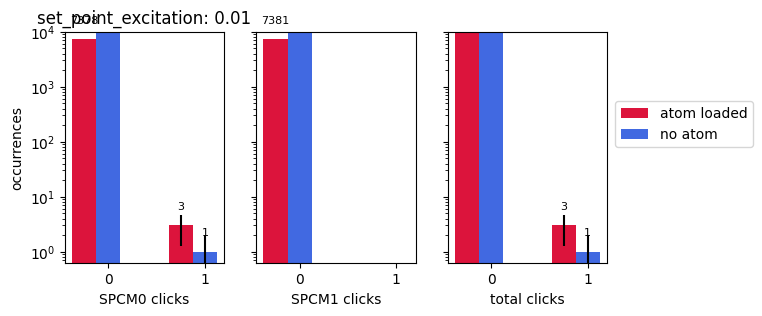

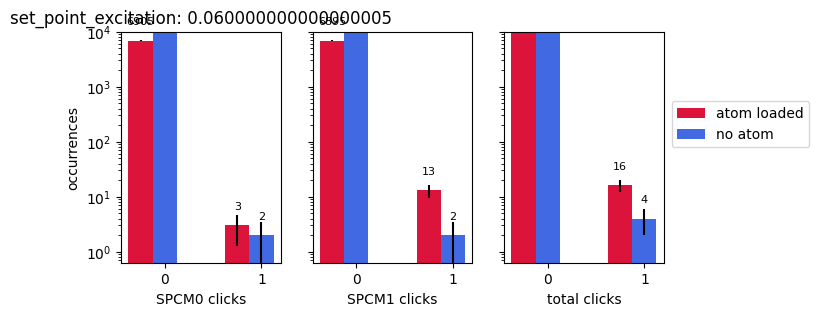

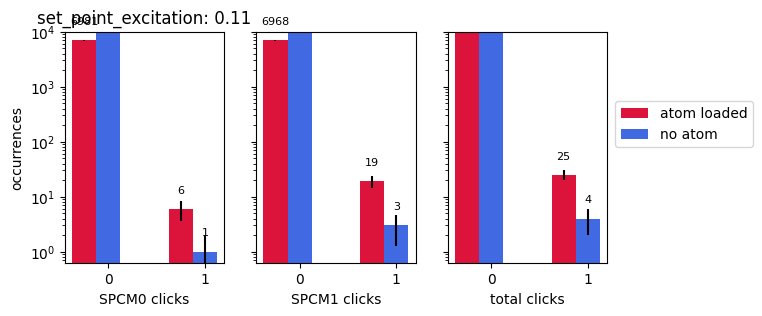

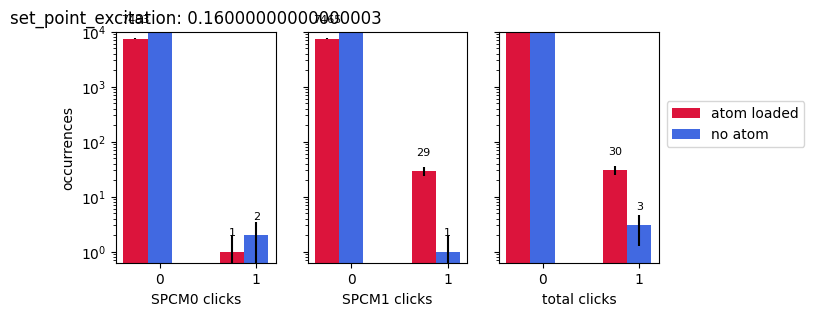

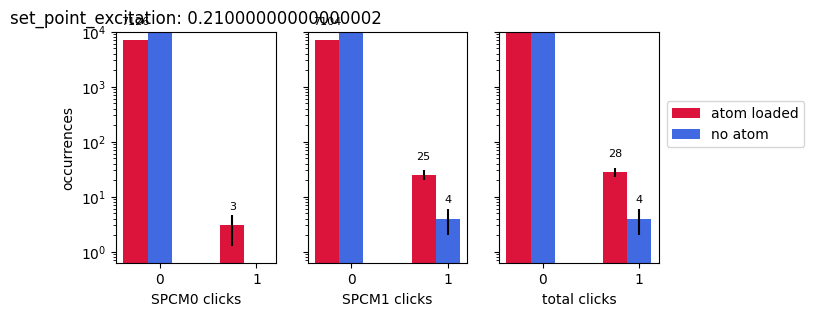

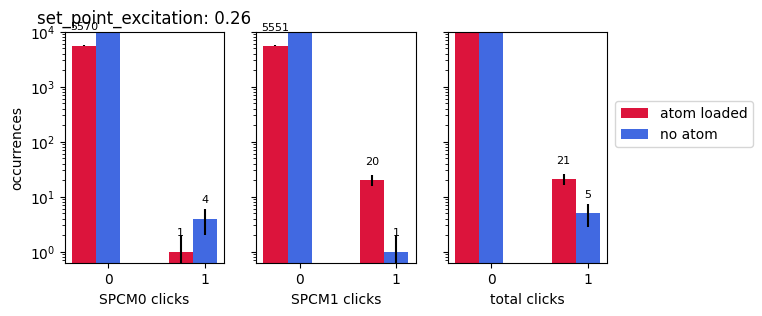

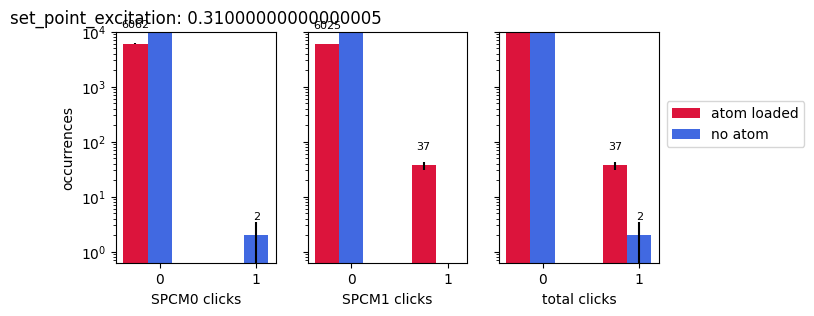

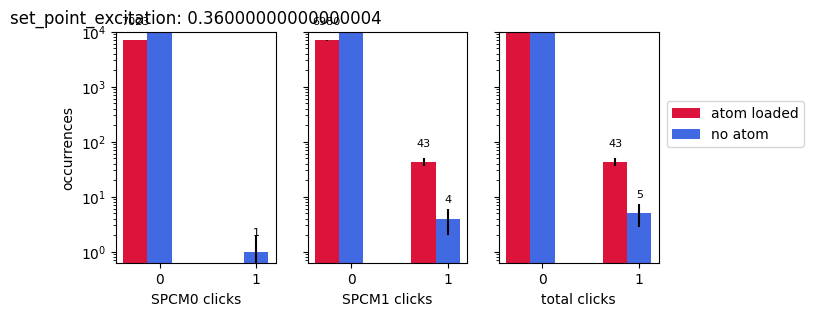

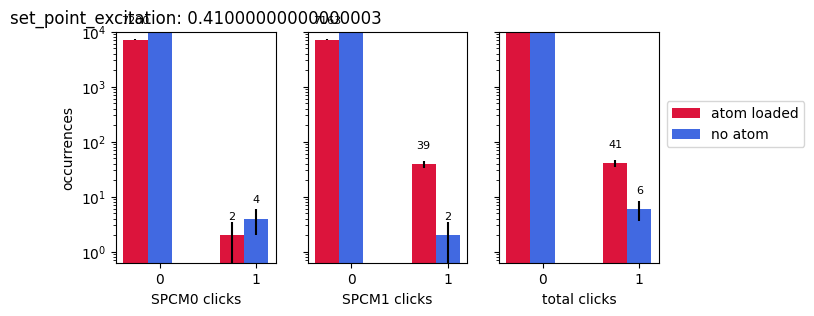

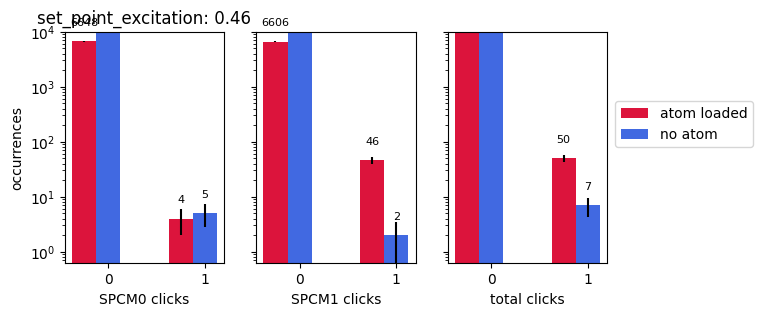

In [253]:
# todo: do not plot bin 0
# cleaning u0

# max_counts = max(excitation_counts)+1
max_counts = max(max(excitation_counts),max(excitation_counts1))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]
units = 1e-9
unit_label = 'ns'

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_loaded_counts_array = np.zeros(iterations)
atom_loaded_fraction_array = np.zeros(iterations)

# atom case
n_SPCM0_atom = np.zeros(iterations)
n_SPCM1_atom = np.zeros(iterations)
n_co_atom = np.zeros(iterations)

# no atom case
n_SPCM0_no_atom = np.zeros(iterations)
n_SPCM1_no_atom = np.zeros(iterations)
n_co_no_atom = np.zeros(iterations)

# g2 calculation
g2_atom = np.zeros(iterations)
g2_no_atom = np.zeros(iterations)


for i, var_value in zip(range(iterations),scan_sequence1):

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars

    # iteration
    # photons are counted from SPCMs 0 and 1 for the excitation phase
    photons_iteration_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    photons1_iteration_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_iteration_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]


    # iteration => n_measurements => n_excitation_cycle
    
    # SPCM0
    photon_counts_with_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts_no_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()
    
    # SPCM1
    photon_counts1_with_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts1_no_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()

    total_photon_counts_with_atom = np.concatenate((photon_counts_with_atom, photon_counts1_with_atom))
    total_photon_counts_no_atom = np.concatenate((photon_counts_no_atom, photon_counts1_no_atom))


    ##### filtering counts using first shot.
    # this is by iteration => change this to => every cycle

    if calculate_g2:
        ### g2 calculation
        # counting count_atom_case & count_no_atom_case - this does the same thing as above - atom_loaded_counts
        filter_atom = readout_iteration_i > cutoff1

        count_atom_case = np.sum(filter_atom)
        count_no_atom_case = len(readout_iteration_i) - count_atom_case
    
        # atom case
        n_SPCM0_atom[i] = np.sum(photon_counts_with_atom)
        n_SPCM1_atom[i] = np.sum(photon_counts1_with_atom)
        n_co_atom[i] = np.sum(photon_counts1_with_atom[photon_counts_with_atom >= 1])
        
        # no atom case
        n_SPCM0_no_atom[i] = np.sum(photon_counts_no_atom)
        n_SPCM1_no_atom[i] = np.sum(photon_counts1_no_atom)
        n_co_no_atom[i] = np.sum(photon_counts1_no_atom[photon_counts_no_atom >= 1])

        # g2 calculation
        g2_atom[i] = n_co_atom[i]/n_SPCM0_atom[i]/n_SPCM1_atom[i]*count_atom_case
        g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


        print("------------------------")
        print(f"{scan_variable1_name} = {var_value} ")
        print("")
        print(f"count_atom_case {count_atom_case}, count_no_atom_case {count_no_atom_case}, total {len(readout_iteration_i)}")
        
        print("")
        print(f"atom case: n_co_atom[i] {n_co_atom[i]}, n_SPCM0_atom[i] {n_SPCM0_atom[i]}, n_SPCM1_atom[i] {(n_SPCM1_atom[i])}")
        print(f"no atom case: n_co_no_atom[i] {n_co_no_atom[i]}, n_SPCM0_no_atom[i] {n_SPCM0_no_atom[i]}, n_SPCM1_no_atom[i] {(n_SPCM1_no_atom[i])}")
        print("")
        print(f"g2_atom[i] = {g2_atom[i]}")
        print(f"g2_no_atom[i] = {g2_no_atom[i]}")

        atom_loaded_counts_array[i] = count_atom_case

    if len(readout_iteration_i) > 0:
        atom_loaded_fraction_array[i] = count_atom_case / len(readout_iteration_i)
    if show_photocount_hist:
        fig,axes = plt.subplots(ncols=3,figsize=(7,3),sharey=True)



    # iterate over the data from the two SPCMs so we can fill in a subplot for each one
    data_idx = 0
    for ax, data_atom, data_no_atom in zip(axes,[photon_counts_with_atom, photon_counts1_with_atom, total_photon_counts_with_atom],
                                           [photon_counts_no_atom, photon_counts1_no_atom, total_photon_counts_no_atom]):
        atom = 1
        multiplier = 0 # moves the bar offset so that atom/no atom bars aren't overlapping
        for data, label, color in zip([data_atom, data_no_atom],barlegend,colors):
            offset = width * multiplier
            binned_data = np.histogram(data, bins=bins)[0]
            if show_photocount_hist:
                rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
                ax.bar_label(rects, padding=10, fontsize=8)
                ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
            multiplier += 1

            # append the data for both SPCMs with/out an atom
            if data_idx==2:
                if atom: 
                    binned_data_with_atom.append(binned_data)
                if not atom: 
                    binned_data_no_atom.append(binned_data)
            atom -= 1
        data_idx += 1
        
    if show_photocount_hist:
        axes[0].set_ylabel('occurrences')
    
        for ax_n, ax in enumerate(axes):
            ax.set_yscale('log')
            ax.set_xticks(x + width, x)
            ax.set_ylim((10**(-0.2),1e4))
            ax.set_xlabel(f'SPCM{ax_n} clicks')
        axes[2].set_xlabel('total clicks')
        axes[-1].legend(loc=(1.05,0.5))
    
        if use_titles:
            axes[0].set_title(titles[i])
        else:
            try:
                axes[0].set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
            except TypeError: # probably a string
                axes[0].set_title(str(var_value)[2:-1])

        
        
    # ax.legend(loc='upper left', ncols=3)

    # fig.tight_layout()
# plt.show()



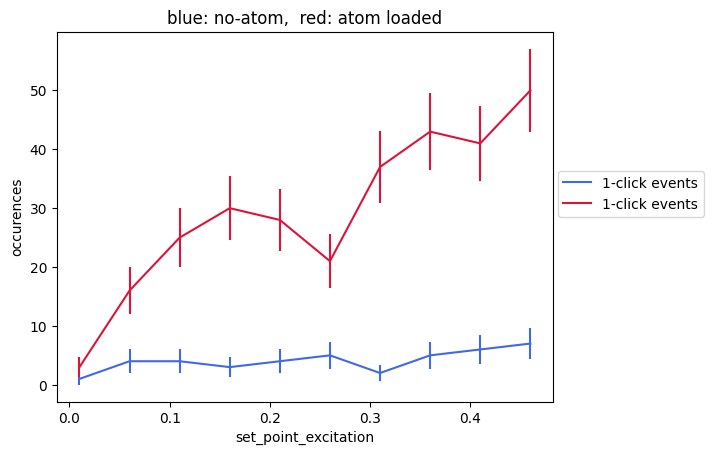

20000

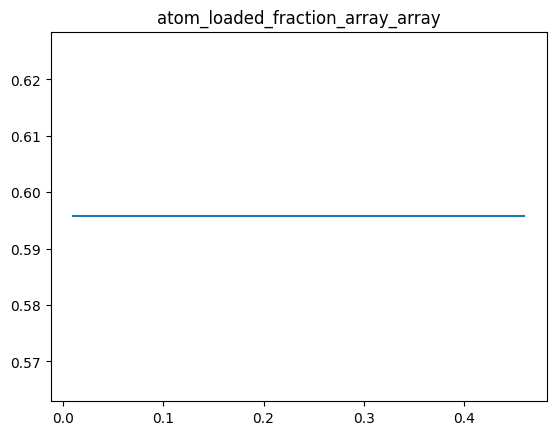

In [254]:
## This will plot total counts from SPCM0 + SPCM1 
## Plot using histogram

counts_data_no_atom = np.array(binned_data_no_atom).transpose()[1:]
counts_data_with_atom = np.array(binned_data_with_atom).transpose()[1:]

linestyles = ['-','--','-.', ':', 'dashdotdotted']
for i in range(max(bins)-1):
    plt.plot(scan_sequence1, counts_data_no_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
    plt.plot(scan_sequence1, counts_data_with_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
    plt.errorbar(scan_sequence1, counts_data_no_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_no_atom[i]], ls='none',color='royalblue')
    plt.errorbar(scan_sequence1, counts_data_with_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_with_atom[i]], ls='none',color='crimson')
plt.legend(loc=(1.01,0.5))
plt.title('blue: no-atom,  red: atom loaded')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)

plt.show()

# # atom_loaded fraction taken into account.
# counts_data_with_atom_norm = [x / y for x, y in zip(counts_data_with_atom, atom_loaded_fraction_array)]
# counts_data_no_atom_norm = [x / (1-y) for x, y in zip(counts_data_no_atom, atom_loaded_fraction_array)]


# linestyles = ['-','--','-.', ':', 'dashdotdotted']
# for i in range(max(bins)-1):
#     plt.plot(scan_sequence1, counts_data_no_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
#     plt.plot(scan_sequence1, counts_data_with_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
# plt.legend(loc=(1.05,0.5))
# plt.title('(blue) red = (no) atom loaded')
# plt.ylabel('occurences')
# plt.xlabel(scan_variable1_name)
# plt.show()


plt.plot(scan_sequence1,atom_loaded_fraction_array)
plt.title("atom_loaded_fraction_array_array")

n_measurements*n_excitation_cycles

## Excitation Setpoint - finer scan - RID 21394

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'gate_start_offset_mu': 750, 'n_excitation_cycles':200, 't_excitation_pulse': 30*ns}
# of iterations:  8


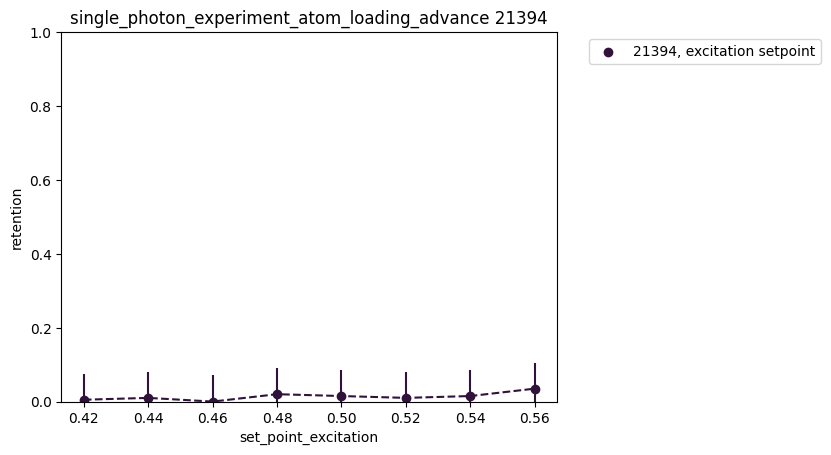

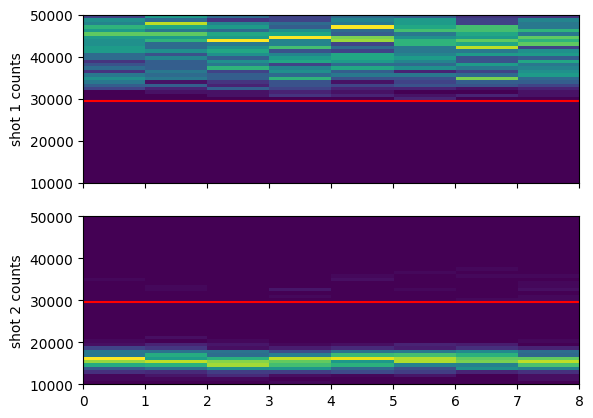

In [122]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = False

show_photocount_hist = True 
calculate_g2 = True


file_indices = {
    37: 'excitation setpoint'
} # the files to plot; 


# for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    # get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


## Excitation Setpoint - finer scan - RID 21394 - Re-analysis

In [230]:
n_atoms_loaded_raveled    

array([[200., 200., 200., 200., 200., 200., 200., 200.]])

In [229]:
loading_rate_array

array([1., 1., 1., 1., 1., 1., 1., 1.])

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'gate_start_offset_mu': 750, 'n_excitation_cycles':200, 't_excitation_pulse': 30*ns}
# of iterations:  8
n_measurements:  200
n_excitation_cycles:  200


C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


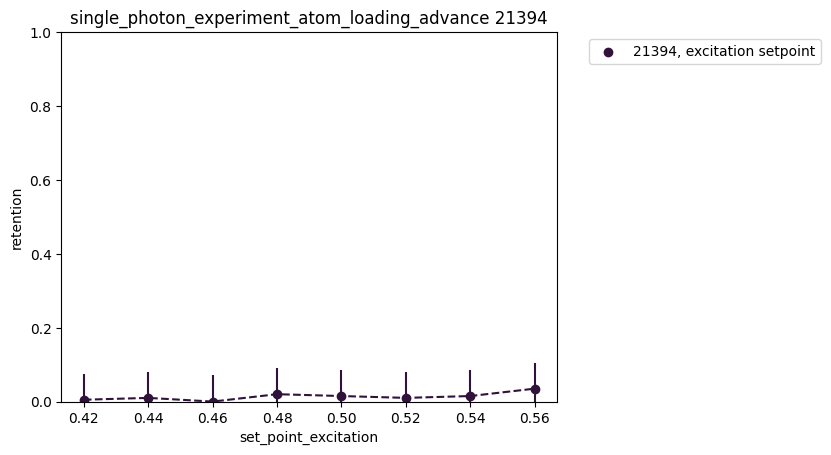

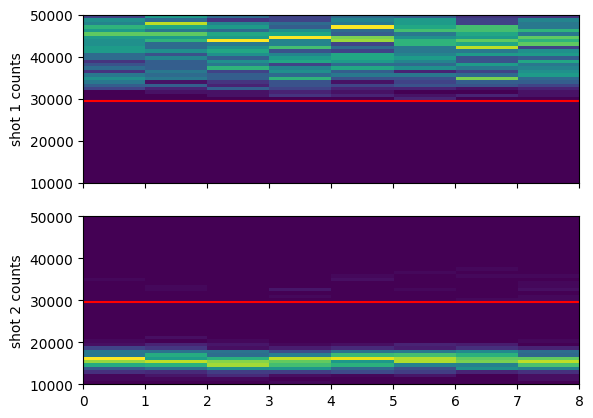

In [245]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = False

show_photocount_hist = True 
calculate_g2 = False


### the files to analyze:
file_indices = {
    37: 'excitation setpoint'
}  


### for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

### for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    print("n_measurements: ", n_measurements)
    print("n_excitation_cycles: ", n_excitation_cycles)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


In [232]:
len(photons1_iteration_i)

40000

In [239]:
# Example array
arr = photons1_iteration_i

# Counting specific values
count_zeros = np.count_nonzero(arr == 0)
count_ones = np.count_nonzero(arr == 1)
count_twos = np.count_nonzero(arr == 2)
count_threes = np.count_nonzero(arr == 3)

print(f"Count of 0's: {count_zeros}")
print(f"Count of 1's: {count_ones}")
print(f"Count of 2's: {count_twos}")
print(f"Count of 3's: {count_threes}")


Count of 0's: 39981
Count of 1's: 12
Count of 2's: 5
Count of 3's: 2


In [235]:
photons1_iteration_i

array([0, 0, 0, ..., 0, 0, 0])

In [164]:
n_measurements*n_excitation_cycles*iterations

320000

In [213]:
len(total_photon_counts_with_atom) + len(total_photon_counts_no_atom)

80000

In [109]:
max(max(excitation_counts),max(excitation_counts1))

3

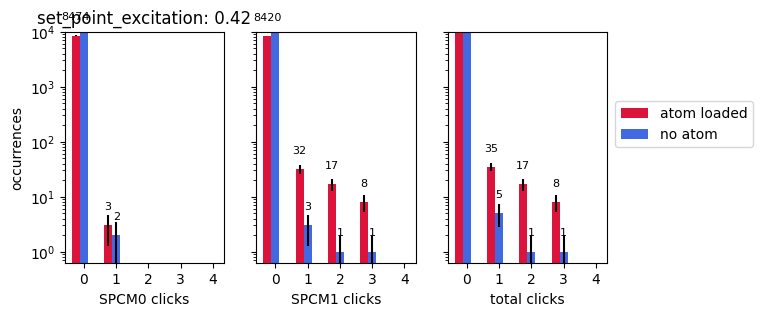

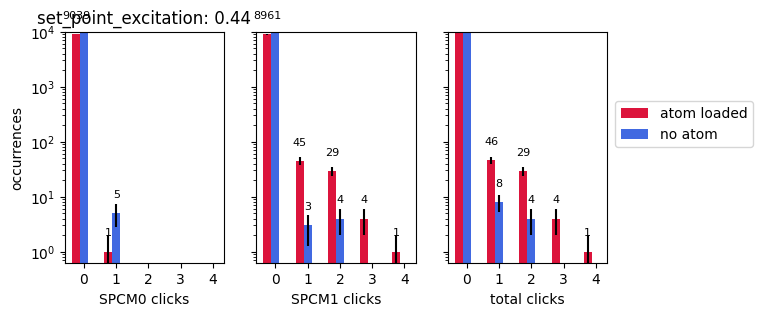

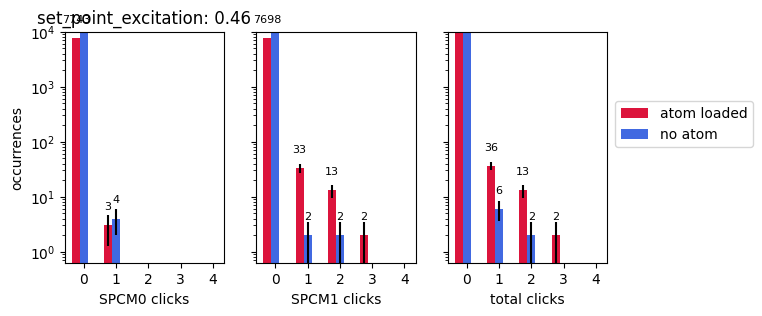

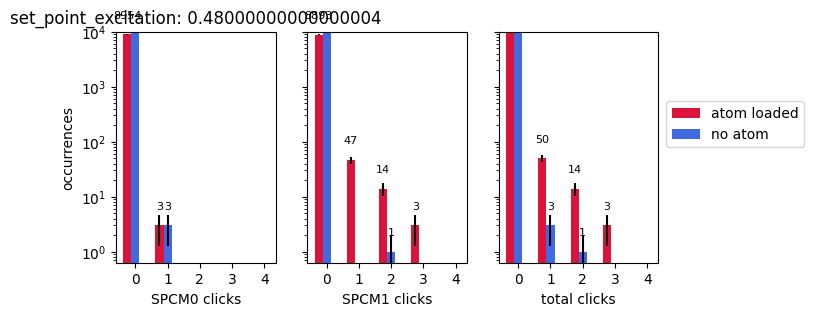

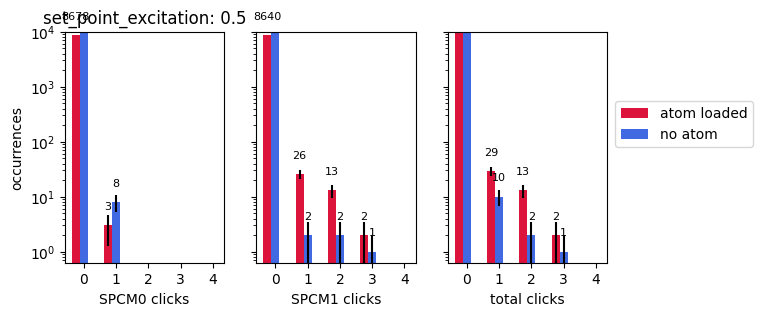

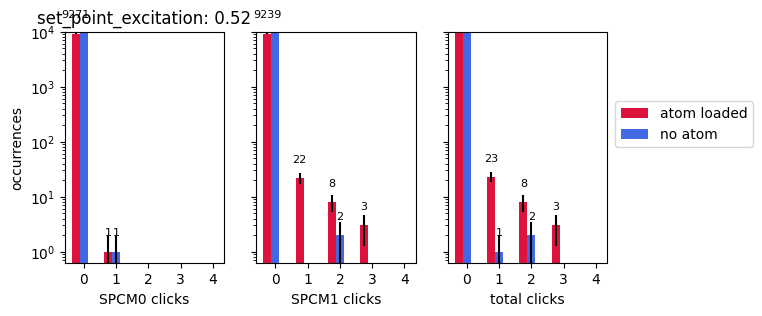

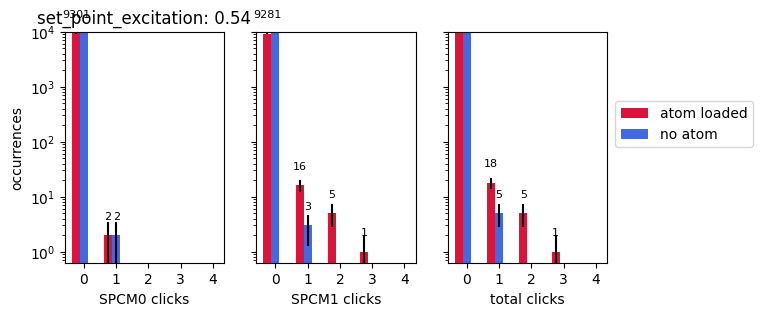

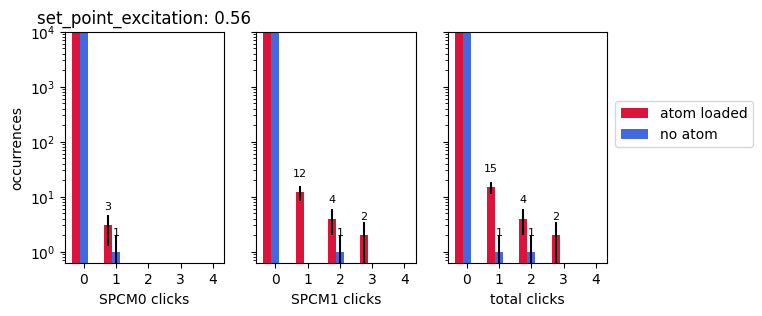

In [250]:
# todo: do not plot bin 0
# cleaning u0

# max_counts = max(excitation_counts)+1
max_counts = max(max(excitation_counts),max(excitation_counts1))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]
units = 1e-9
unit_label = 'ns'

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_loaded_counts_array = np.zeros(iterations)
atom_loaded_fraction_array = np.zeros(iterations)

# atom case
n_SPCM0_atom = np.zeros(iterations)
n_SPCM1_atom = np.zeros(iterations)
n_co_atom = np.zeros(iterations)

# no atom case
n_SPCM0_no_atom = np.zeros(iterations)
n_SPCM1_no_atom = np.zeros(iterations)
n_co_no_atom = np.zeros(iterations)

# g2 calculation
g2_atom = np.zeros(iterations)
g2_no_atom = np.zeros(iterations)


for i, var_value in zip(range(iterations),scan_sequence1):

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars

    # iteration
    # photons are counted from SPCMs 0 and 1 for the excitation phase
    photons_iteration_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    photons1_iteration_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_iteration_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]


    # iteration => n_measurements => n_excitation_cycle
    
    # SPCM0
    photon_counts_with_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts_no_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()
    
    # SPCM1
    photon_counts1_with_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts1_no_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()

    total_photon_counts_with_atom = np.concatenate((photon_counts_with_atom, photon_counts1_with_atom))
    total_photon_counts_no_atom = np.concatenate((photon_counts_no_atom, photon_counts1_no_atom))


    ##### filtering counts using first shot.
    # this is by iteration => change this to => every cycle

    if calculate_g2:
        ### g2 calculation
        # counting count_atom_case & count_no_atom_case - this does the same thing as above - atom_loaded_counts
        filter_atom = readout_iteration_i > cutoff1

        count_atom_case = np.sum(filter_atom)
        count_no_atom_case = len(readout_iteration_i) - count_atom_case
    
        # atom case
        n_SPCM0_atom[i] = np.sum(photon_counts_with_atom)
        n_SPCM1_atom[i] = np.sum(photon_counts1_with_atom)
        n_co_atom[i] = np.sum(photon_counts1_with_atom[photon_counts_with_atom >= 1])
        
        # no atom case
        n_SPCM0_no_atom[i] = np.sum(photon_counts_no_atom)
        n_SPCM1_no_atom[i] = np.sum(photon_counts1_no_atom)
        n_co_no_atom[i] = np.sum(photon_counts1_no_atom[photon_counts_no_atom >= 1])

        # g2 calculation
        g2_atom[i] = n_co_atom[i]/n_SPCM0_atom[i]/n_SPCM1_atom[i]*count_atom_case
        g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


        print("------------------------")
        print(f"{scan_variable1_name} = {var_value} ")
        print("")
        print(f"count_atom_case {count_atom_case}, count_no_atom_case {count_no_atom_case}, total {len(readout_iteration_i)}")
        
        print("")
        print(f"atom case: n_co_atom[i] {n_co_atom[i]}, n_SPCM0_atom[i] {n_SPCM0_atom[i]}, n_SPCM1_atom[i] {(n_SPCM1_atom[i])}")
        print(f"no atom case: n_co_no_atom[i] {n_co_no_atom[i]}, n_SPCM0_no_atom[i] {n_SPCM0_no_atom[i]}, n_SPCM1_no_atom[i] {(n_SPCM1_no_atom[i])}")
        print("")
        print(f"g2_atom[i] = {g2_atom[i]}")
        print(f"g2_no_atom[i] = {g2_no_atom[i]}")

        atom_loaded_counts_array[i] = count_atom_case

    if len(readout_iteration_i) > 0:
        atom_loaded_fraction_array[i] = count_atom_case / len(readout_iteration_i)
    if show_photocount_hist:
        fig,axes = plt.subplots(ncols=3,figsize=(7,3),sharey=True)



    # iterate over the data from the two SPCMs so we can fill in a subplot for each one
    data_idx = 0
    for ax, data_atom, data_no_atom in zip(axes,[photon_counts_with_atom, photon_counts1_with_atom, total_photon_counts_with_atom],
                                           [photon_counts_no_atom, photon_counts1_no_atom, total_photon_counts_no_atom]):
        atom = 1
        multiplier = 0 # moves the bar offset so that atom/no atom bars aren't overlapping
        for data, label, color in zip([data_atom, data_no_atom],barlegend,colors):
            offset = width * multiplier
            binned_data = np.histogram(data, bins=bins)[0]
            if show_photocount_hist:
                rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
                ax.bar_label(rects, padding=10, fontsize=8)
                ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
            multiplier += 1

            # append the data for both SPCMs with/out an atom
            if data_idx==2:
                if atom: 
                    binned_data_with_atom.append(binned_data)
                if not atom: 
                    binned_data_no_atom.append(binned_data)
            atom -= 1
        data_idx += 1
        
    if show_photocount_hist:
        axes[0].set_ylabel('occurrences')
    
        for ax_n, ax in enumerate(axes):
            ax.set_yscale('log')
            ax.set_xticks(x + width, x)
            ax.set_ylim((10**(-0.2),1e4))
            ax.set_xlabel(f'SPCM{ax_n} clicks')
        axes[2].set_xlabel('total clicks')
        axes[-1].legend(loc=(1.05,0.5))
    
        if use_titles:
            axes[0].set_title(titles[i])
        else:
            try:
                axes[0].set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
            except TypeError: # probably a string
                axes[0].set_title(str(var_value)[2:-1])

        
        
    # ax.legend(loc='upper left', ncols=3)

    # fig.tight_layout()
# plt.show()



In [210]:
len(readout_iteration_i)

40000

In [207]:
len(photon_counts_with_atom)

11914

In [188]:
counts_data_with_atom

array([[35, 46, 36, 50, 29, 23, 18, 15],
       [17, 29, 13, 14, 13,  8,  5,  4],
       [ 8,  4,  2,  3,  2,  3,  1,  2],
       [ 0,  1,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [189]:
binned_data_with_atom

[array([16894,    35,    17,     8,     0], dtype=int64),
 array([18000,    46,    29,     4,     1], dtype=int64),
 array([15441,    36,    13,     2,     0], dtype=int64),
 array([17847,    50,    14,     3,     0], dtype=int64),
 array([17318,    29,    13,     2,     0], dtype=int64),
 array([18510,    23,     8,     3,     0], dtype=int64),
 array([18582,    18,     5,     1,     0], dtype=int64),
 array([23807,    15,     4,     2,     0], dtype=int64)]

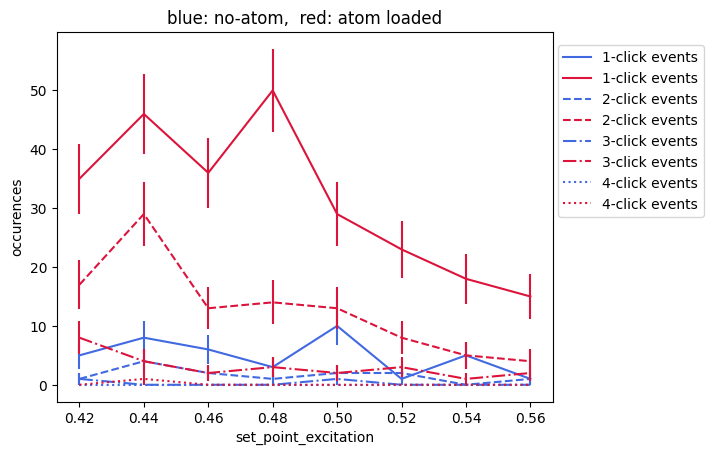

40000

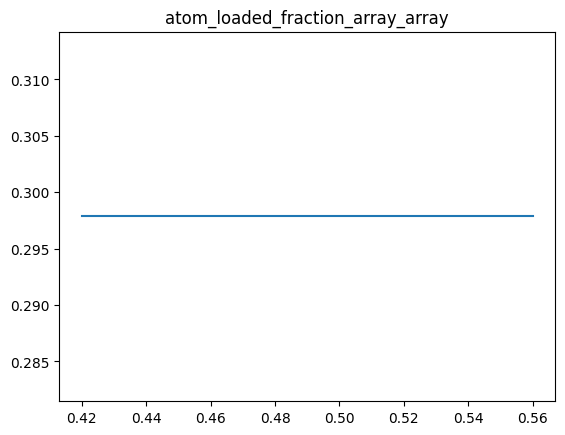

In [247]:
## This will plot total counts from SPCM0 + SPCM1 
## Plot using histogram

counts_data_no_atom = np.array(binned_data_no_atom).transpose()[1:]
counts_data_with_atom = np.array(binned_data_with_atom).transpose()[1:]

linestyles = ['-','--','-.', ':', 'dashdotdotted']
for i in range(max(bins)-1):
    plt.plot(scan_sequence1, counts_data_no_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
    plt.plot(scan_sequence1, counts_data_with_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
    plt.errorbar(scan_sequence1, counts_data_no_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_no_atom[i]], ls='none',color='royalblue')
    plt.errorbar(scan_sequence1, counts_data_with_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_with_atom[i]], ls='none',color='crimson')
plt.legend(loc=(1.01,0.5))
plt.title('blue: no-atom,  red: atom loaded')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)

plt.show()

# # atom_loaded fraction taken into account.
# counts_data_with_atom_norm = [x / y for x, y in zip(counts_data_with_atom, atom_loaded_fraction_array)]
# counts_data_no_atom_norm = [x / (1-y) for x, y in zip(counts_data_no_atom, atom_loaded_fraction_array)]


# linestyles = ['-','--','-.', ':', 'dashdotdotted']
# for i in range(max(bins)-1):
#     plt.plot(scan_sequence1, counts_data_no_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
#     plt.plot(scan_sequence1, counts_data_with_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
# plt.legend(loc=(1.05,0.5))
# plt.title('(blue) red = (no) atom loaded')
# plt.ylabel('occurences')
# plt.xlabel(scan_variable1_name)
# plt.show()


plt.plot(scan_sequence1,atom_loaded_fraction_array)
plt.title("atom_loaded_fraction_array_array")

n_measurements*n_excitation_cycles

## Excitation Setpoint - RID 21391

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'gate_start_offset_mu': 750, 'n_excitation_cycles':100, 't_excitation_pulse': 30*ns}
# of iterations:  6


C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


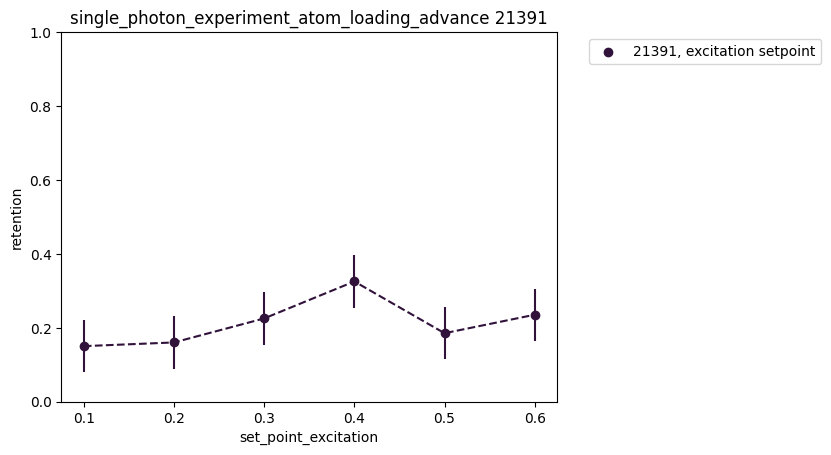

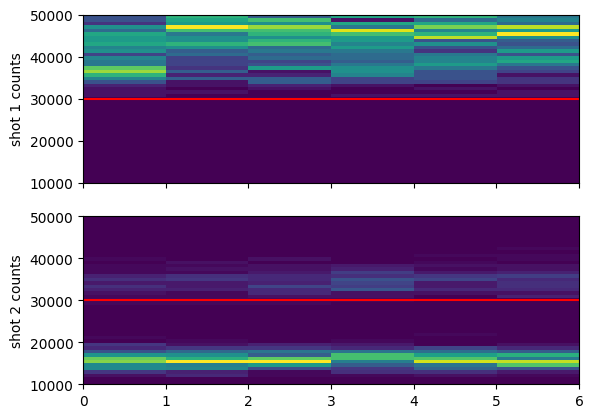

In [113]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = False

show_photocount_hist = True 
calculate_g2 = True


file_indices = {
    35: 'excitation setpoint'
} # the files to plot; 


# for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    # get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


In [109]:
max(max(excitation_counts),max(excitation_counts1))

3

C:\Users\QC\AppData\Local\Temp\ipykernel_336\3782318866.py:86: RuntimeWarning: invalid value encountered in scalar divide
  g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case
C:\Users\QC\AppData\Local\Temp\ipykernel_336\3782318866.py:86: RuntimeWarning: invalid value encountered in scalar divide
  g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


------------------------
set_point_excitation = 0.1 

count_atom_case 8556, count_no_atom_case 11444, total 20000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 1.0, n_SPCM1_atom[i] 2.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 4.0, n_SPCM1_no_atom[i] 0.0

g2_atom[i] = 0.0
g2_no_atom[i] = nan
------------------------
set_point_excitation = 0.2 

count_atom_case 9085, count_no_atom_case 10915, total 20000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 1.0, n_SPCM1_atom[i] 12.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 2.0, n_SPCM1_no_atom[i] 0.0

g2_atom[i] = 0.0
g2_no_atom[i] = nan
------------------------
set_point_excitation = 0.30000000000000004 

count_atom_case 11262, count_no_atom_case 8738, total 20000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 6.0, n_SPCM1_atom[i] 41.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 1.0, n_SPCM1_no_atom[i] 3.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
set_point_excitation = 0.4 

count_atom_ca

C:\Users\QC\AppData\Local\Temp\ipykernel_336\3782318866.py:86: RuntimeWarning: invalid value encountered in scalar divide
  g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


------------------------
set_point_excitation = 0.5 

count_atom_case 10143, count_no_atom_case 9857, total 20000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 3.0, n_SPCM1_atom[i] 118.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 0.0, n_SPCM1_no_atom[i] 3.0

g2_atom[i] = 0.0
g2_no_atom[i] = nan


C:\Users\QC\AppData\Local\Temp\ipykernel_336\3782318866.py:86: RuntimeWarning: invalid value encountered in scalar divide
  g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


------------------------
set_point_excitation = 0.6 

count_atom_case 10484, count_no_atom_case 9516, total 20000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 5.0, n_SPCM1_atom[i] 102.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 0.0, n_SPCM1_no_atom[i] 2.0

g2_atom[i] = 0.0
g2_no_atom[i] = nan


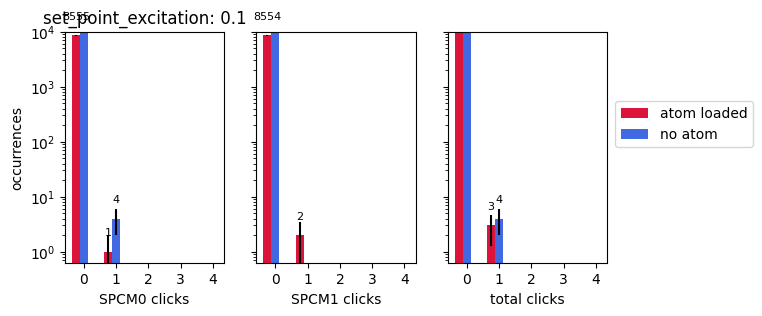

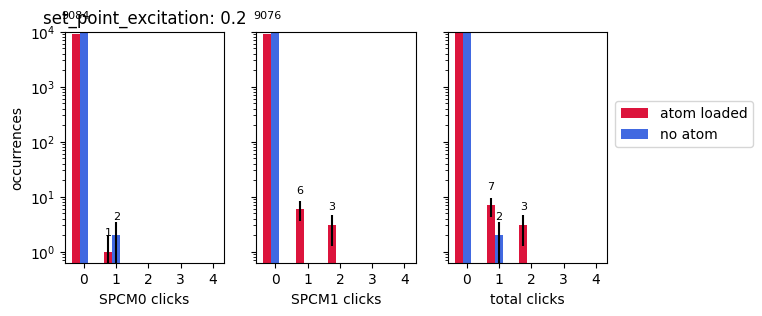

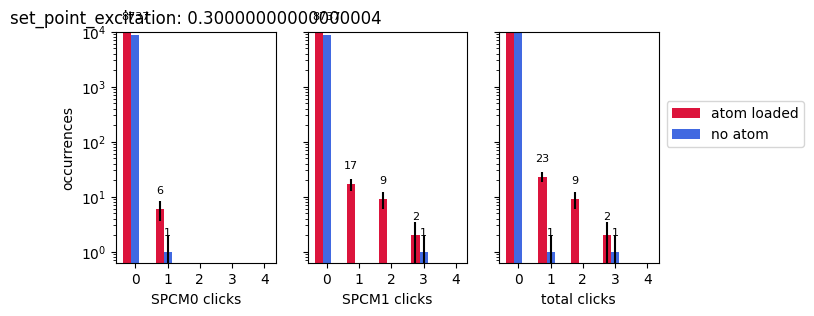

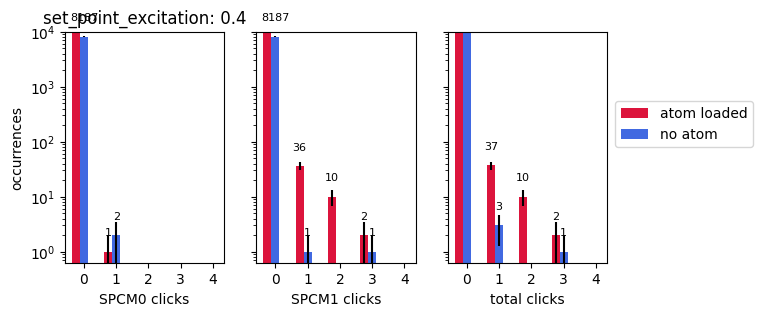

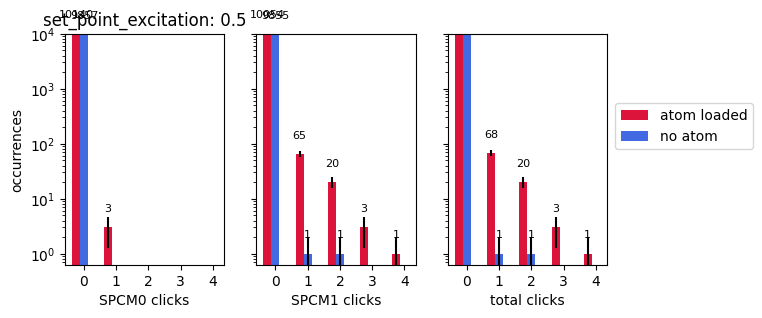

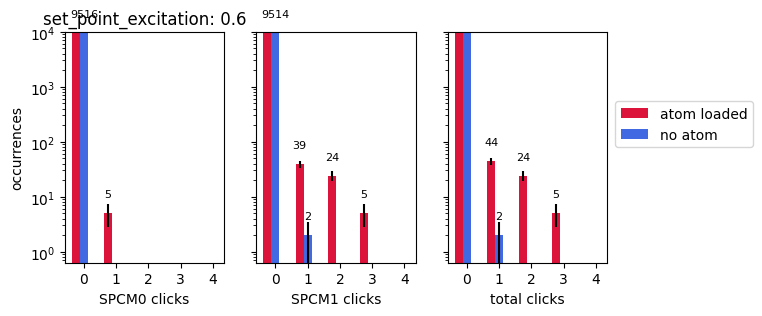

In [114]:
# todo: do not plot bin 0
# cleaning u0

# max_counts = max(excitation_counts)+1
max_counts = max(max(excitation_counts),max(excitation_counts1))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]
units = 1e-9
unit_label = 'ns'

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_loaded_counts_array = np.zeros(iterations)
atom_loaded_fraction_array = np.zeros(iterations)

# atom case
n_SPCM0_atom = np.zeros(iterations)
n_SPCM1_atom = np.zeros(iterations)
n_co_atom = np.zeros(iterations)

# no atom case
n_SPCM0_no_atom = np.zeros(iterations)
n_SPCM1_no_atom = np.zeros(iterations)
n_co_no_atom = np.zeros(iterations)

# g2 calculation
g2_atom = np.zeros(iterations)
g2_no_atom = np.zeros(iterations)


for i, var_value in zip(range(iterations),scan_sequence1):

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars

    # iteration
    # photons are counted from SPCMs 0 and 1 for the excitation phase
    photons_iteration_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    photons1_iteration_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_iteration_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]


    # iteration => n_measurements => n_excitation_cycle
    
    # SPCM0
    photon_counts_with_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts_no_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()
    
    # SPCM1
    photon_counts1_with_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts1_no_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()

    total_photon_counts_with_atom = np.concatenate((photon_counts_with_atom, photon_counts1_with_atom))
    total_photon_counts_no_atom = np.concatenate((photon_counts_no_atom, photon_counts1_no_atom))


    ##### filtering counts using first shot.
    # this is by iteration => change this to => every cycle

    if calculate_g2:
        ### g2 calculation
        # counting count_atom_case & count_no_atom_case - this does the same thing as above - atom_loaded_counts
        filter_atom = readout_iteration_i > cutoff1

        count_atom_case = np.sum(filter_atom)
        count_no_atom_case = len(readout_iteration_i) - count_atom_case
    
        # atom case
        n_SPCM0_atom[i] = np.sum(photon_counts_with_atom)
        n_SPCM1_atom[i] = np.sum(photon_counts1_with_atom)
        n_co_atom[i] = np.sum(photon_counts1_with_atom[photon_counts_with_atom >= 1])
        
        # no atom case
        n_SPCM0_no_atom[i] = np.sum(photon_counts_no_atom)
        n_SPCM1_no_atom[i] = np.sum(photon_counts1_no_atom)
        n_co_no_atom[i] = np.sum(photon_counts1_no_atom[photon_counts_no_atom >= 1])

        # g2 calculation
        g2_atom[i] = n_co_atom[i]/n_SPCM0_atom[i]/n_SPCM1_atom[i]*count_atom_case
        g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


        print("------------------------")
        print(f"{scan_variable1_name} = {var_value} ")
        print("")
        print(f"count_atom_case {count_atom_case}, count_no_atom_case {count_no_atom_case}, total {len(readout_iteration_i)}")
        
        print("")
        print(f"atom case: n_co_atom[i] {n_co_atom[i]}, n_SPCM0_atom[i] {n_SPCM0_atom[i]}, n_SPCM1_atom[i] {(n_SPCM1_atom[i])}")
        print(f"no atom case: n_co_no_atom[i] {n_co_no_atom[i]}, n_SPCM0_no_atom[i] {n_SPCM0_no_atom[i]}, n_SPCM1_no_atom[i] {(n_SPCM1_no_atom[i])}")
        print("")
        print(f"g2_atom[i] = {g2_atom[i]}")
        print(f"g2_no_atom[i] = {g2_no_atom[i]}")

        atom_loaded_counts_array[i] = count_atom_case

        if len(readout_iteration_i) > 0:
            atom_loaded_fraction_array[i] = count_atom_case / len(readout_iteration_i)
        if show_photocount_hist:
            fig,axes = plt.subplots(ncols=3,figsize=(7,3),sharey=True)



    # iterate over the data from the two SPCMs so we can fill in a subplot for each one
    data_idx = 0
    for ax, data_atom, data_no_atom in zip(axes,[photon_counts_with_atom, photon_counts1_with_atom, total_photon_counts_with_atom],
                                           [photon_counts_no_atom, photon_counts1_no_atom, total_photon_counts_no_atom]):
        atom = 1
        multiplier = 0 # moves the bar offset so that atom/no atom bars aren't overlapping
        for data, label, color in zip([data_atom, data_no_atom],barlegend,colors):
            offset = width * multiplier
            binned_data = np.histogram(data, bins=bins)[0]
            if show_photocount_hist:
                rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
                ax.bar_label(rects, padding=10, fontsize=8)
                ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
            multiplier += 1

            # append the data for both SPCMs with/out an atom
            if data_idx==2:
                if atom: 
                    binned_data_with_atom.append(binned_data)
                if not atom: 
                    binned_data_no_atom.append(binned_data)
            atom -= 1
        data_idx += 1
        
    if show_photocount_hist:
        axes[0].set_ylabel('occurrences')
    
        for ax_n, ax in enumerate(axes):
            ax.set_yscale('log')
            ax.set_xticks(x + width, x)
            ax.set_ylim((10**(-0.2),1e4))
            ax.set_xlabel(f'SPCM{ax_n} clicks')
        axes[2].set_xlabel('total clicks')
        axes[-1].legend(loc=(1.05,0.5))
    
        if use_titles:
            axes[0].set_title(titles[i])
        else:
            try:
                axes[0].set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
            except TypeError: # probably a string
                axes[0].set_title(str(var_value)[2:-1])

        
        
    # ax.legend(loc='upper left', ncols=3)

    # fig.tight_layout()
# plt.show()



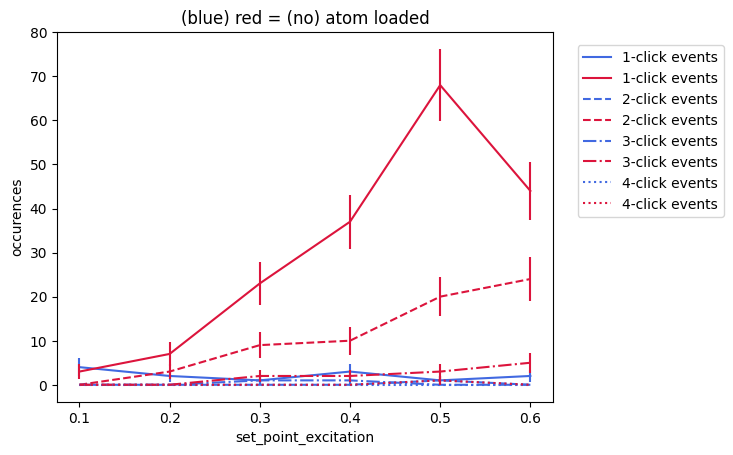

20000

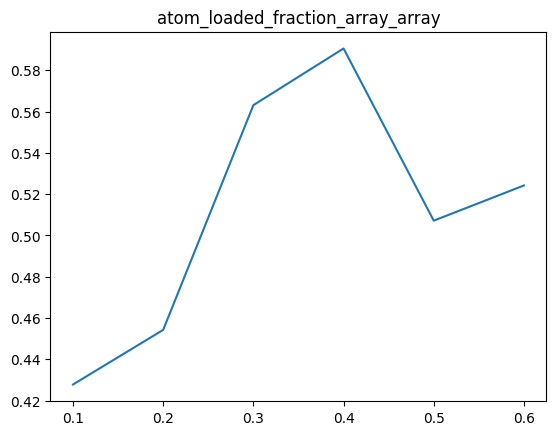

In [119]:
## total counts from SPCM0 + SPCM1 
## Plot using histogram

counts_data_no_atom = np.array(binned_data_no_atom).transpose()[1:]
counts_data_with_atom = np.array(binned_data_with_atom).transpose()[1:]

linestyles = ['-','--','-.', ':', 'dashdotdotted']
for i in range(max(bins)-1):
    plt.plot(scan_sequence1, counts_data_no_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
    plt.plot(scan_sequence1, counts_data_with_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
    plt.errorbar(scan_sequence1, counts_data_no_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_no_atom[i]], ls='none',color='royalblue')
    plt.errorbar(scan_sequence1, counts_data_with_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_with_atom[i]], ls='none',color='crimson')
plt.legend(loc=(1.05,0.5))
plt.title('(blue) red = (no) atom loaded')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)

plt.show()

# # atom_loaded fraction taken into account.
# counts_data_with_atom_norm = [x / y for x, y in zip(counts_data_with_atom, atom_loaded_fraction_array)]
# counts_data_no_atom_norm = [x / (1-y) for x, y in zip(counts_data_no_atom, atom_loaded_fraction_array)]


# linestyles = ['-','--','-.', ':', 'dashdotdotted']
# for i in range(max(bins)-1):
#     plt.plot(scan_sequence1, counts_data_no_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
#     plt.plot(scan_sequence1, counts_data_with_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
# plt.legend(loc=(1.05,0.5))
# plt.title('(blue) red = (no) atom loaded')
# plt.ylabel('occurences')
# plt.xlabel(scan_variable1_name)
# plt.show()


plt.plot(scan_sequence1,atom_loaded_fraction_array)
plt.title("atom_loaded_fraction_array_array")

n_measurements*n_excitation_cycles

# 2024.12.27

In [15]:
fnames = get_files_by_criteria(date_filters=["2024-12-26"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-26\19\000020916-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_gate_start_offset_mu.h5, which is corrupt
found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-26\15\000020906-GeneralVariableScan.h5) scanned over gate_start_offset_mu
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-26\15\000020906-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_gate_start_offset_mu.h5) scanned over gate_start_offset_mu
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-26\19\000020916-GeneralVariableScan.h5) scanned over gate_start_offset_mu


## gate_start_offset - n_measurement = 100; somehow it just set to this itself

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'n_measurements': 250,'require_atom_loading_to_advance_in_single_photon_exp': True,'t_recooling':5*ms,'n_excitation_cycles': 200, 'set_point_excitation': .19}
# of iterations:  16


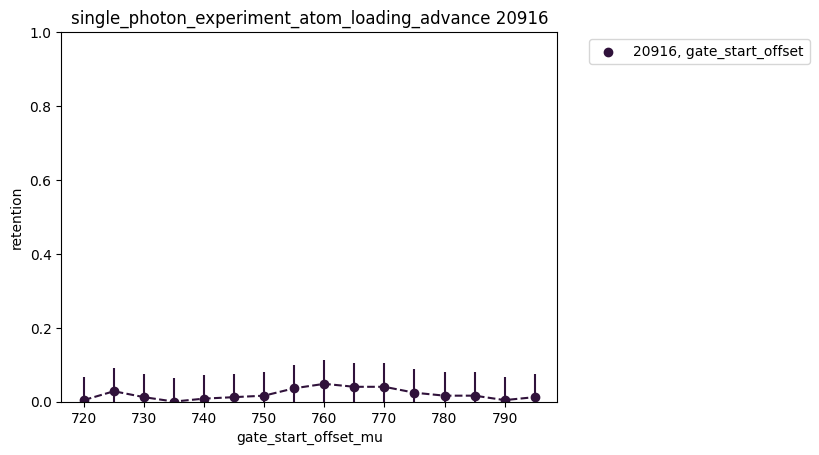

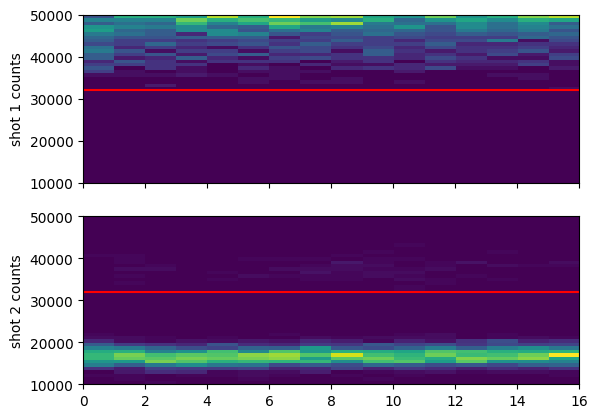

In [32]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = False

show_photocount_hist = True 
calculate_g2 = True


file_indices = {
    2: 'gate_start_offset'
} # the files to plot; 


# for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    # get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


In [109]:
max(max(excitation_counts),max(excitation_counts1))

3

------------------------
gate_start_offset_mu = 720 

count_atom_case 11094, count_no_atom_case 38906, total 50000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 2.0, n_SPCM1_atom[i] 22.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 4.0, n_SPCM1_no_atom[i] 1.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
gate_start_offset_mu = 725 

count_atom_case 12834, count_no_atom_case 37166, total 50000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 2.0, n_SPCM1_atom[i] 15.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 9.0, n_SPCM1_no_atom[i] 1.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
gate_start_offset_mu = 730 

count_atom_case 10247, count_no_atom_case 39753, total 50000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 4.0, n_SPCM1_atom[i] 14.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 11.0, n_SPCM1_no_atom[i] 1.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
gate_start_offset_mu = 735 

count_atom_case 8587, co

C:\Users\QC\AppData\Local\Temp\ipykernel_336\2665069287.py:88: RuntimeWarning: invalid value encountered in scalar divide
  g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


------------------------
gate_start_offset_mu = 740 

count_atom_case 9707, count_no_atom_case 40293, total 50000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 1.0, n_SPCM1_atom[i] 6.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 7.0, n_SPCM1_no_atom[i] 2.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
gate_start_offset_mu = 745 

count_atom_case 11218, count_no_atom_case 38782, total 50000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 3.0, n_SPCM1_atom[i] 5.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 4.0, n_SPCM1_no_atom[i] 2.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
gate_start_offset_mu = 750 

count_atom_case 12911, count_no_atom_case 37089, total 50000

atom case: n_co_atom[i] 0.0, n_SPCM0_atom[i] 3.0, n_SPCM1_atom[i] 2.0
no atom case: n_co_no_atom[i] 0.0, n_SPCM0_no_atom[i] 5.0, n_SPCM1_no_atom[i] 1.0

g2_atom[i] = 0.0
g2_no_atom[i] = 0.0
------------------------
gate_start_offset_mu = 755 

count_atom_case 14449, count_

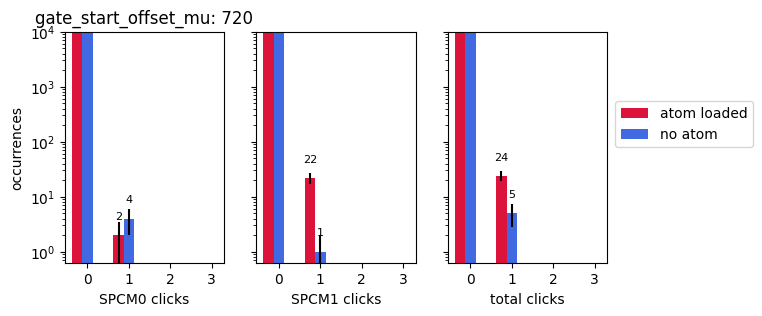

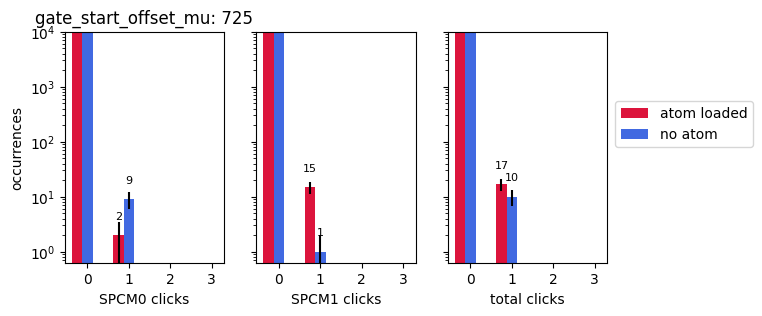

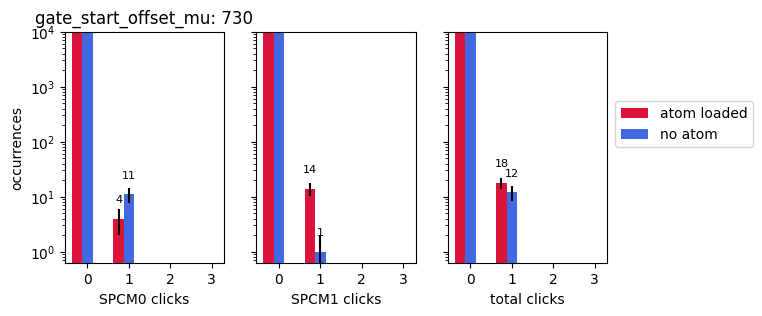

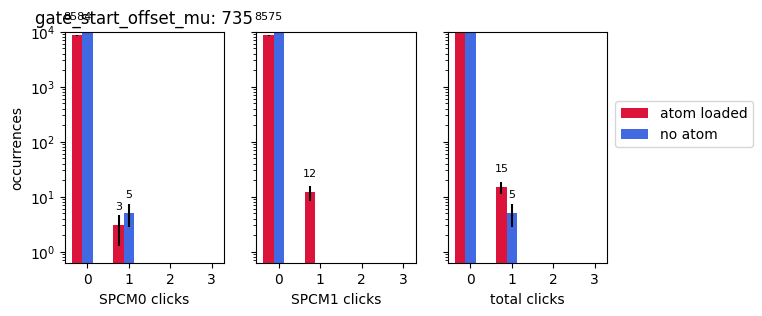

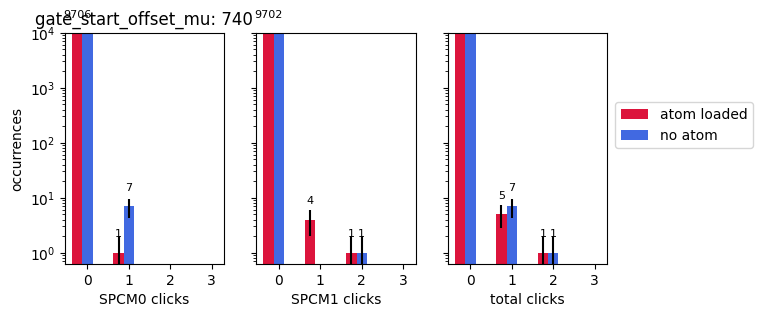

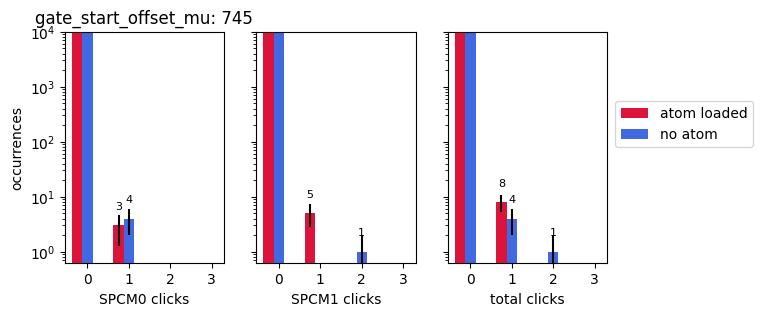

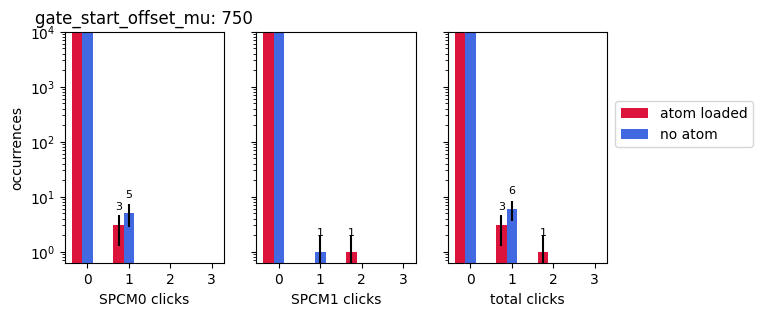

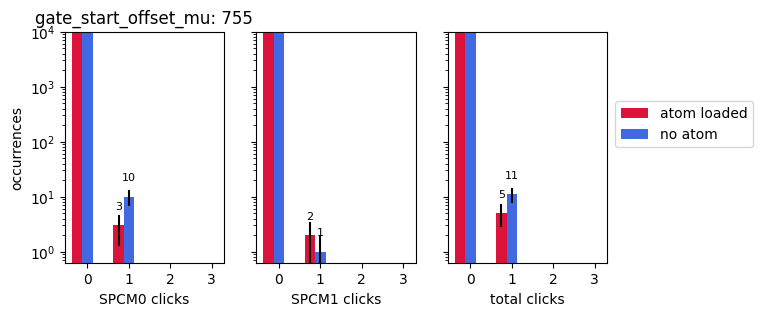

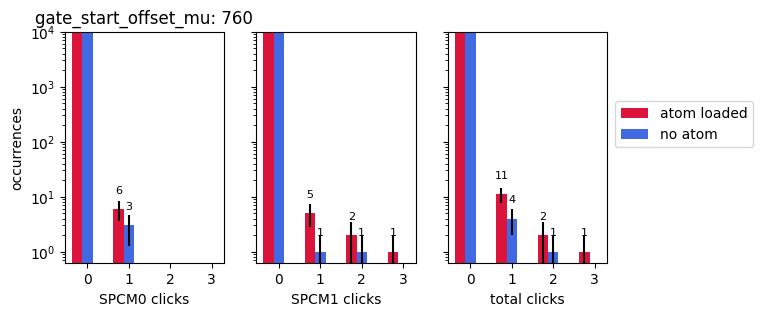

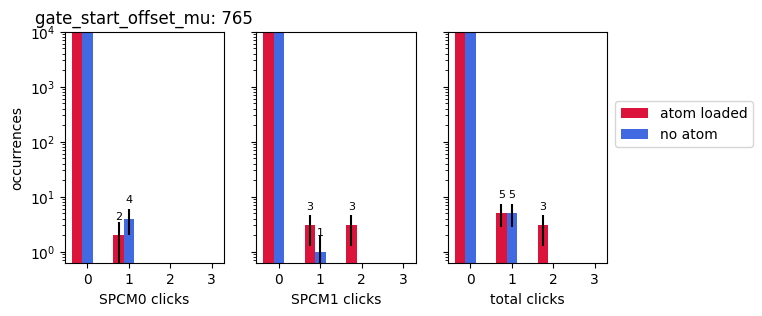

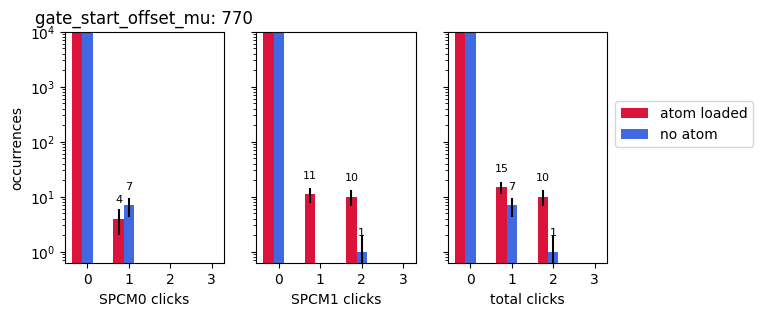

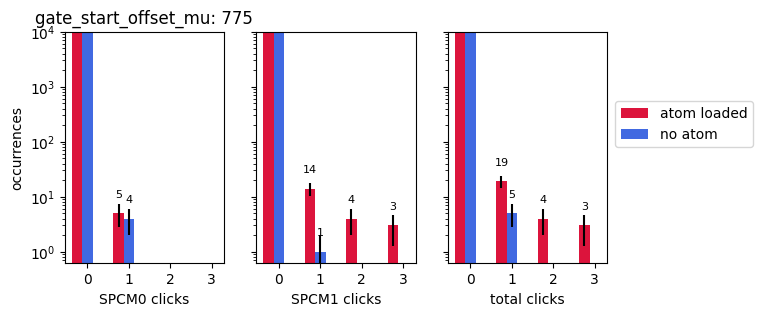

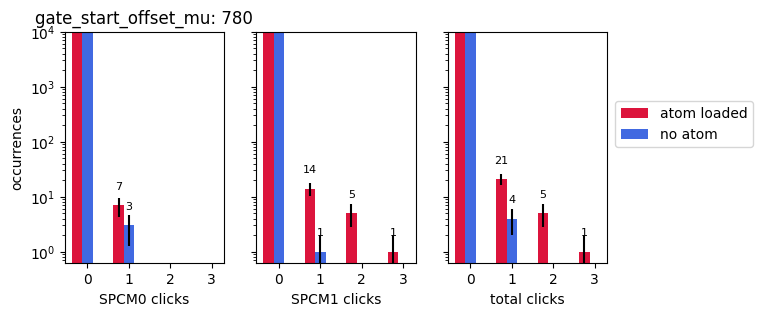

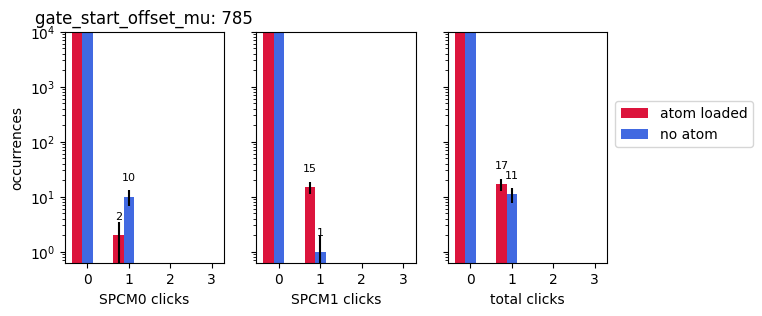

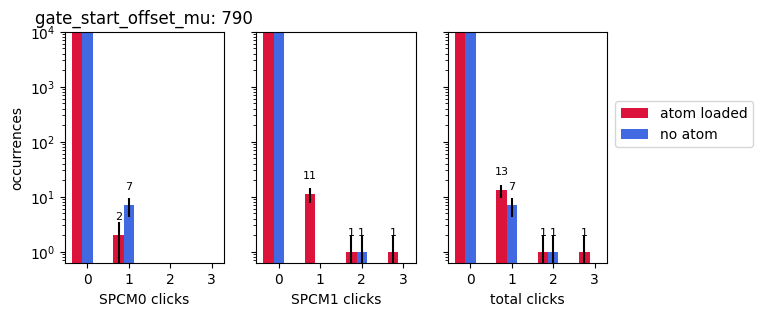

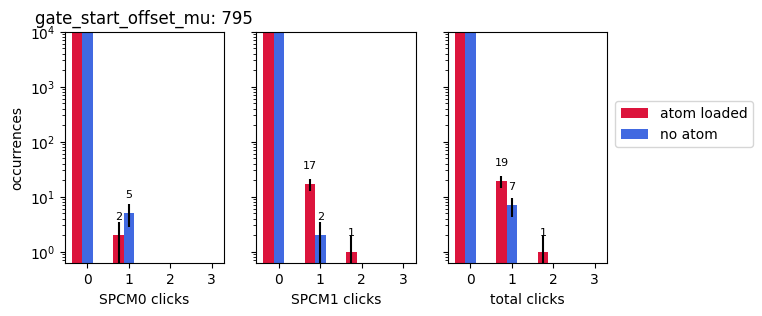

In [110]:
# todo: do not plot bin 0
# cleaning u0

# max_counts = max(excitation_counts)+1
max_counts = max(max(excitation_counts),max(excitation_counts1))+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]
units = 1e-9
unit_label = 'ns'

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_loaded_counts_array = np.zeros(iterations)
atom_loaded_fraction_array = np.zeros(iterations)

# atom case
n_SPCM0_atom = np.zeros(iterations)
n_SPCM1_atom = np.zeros(iterations)
n_co_atom = np.zeros(iterations)

# no atom case
n_SPCM0_no_atom = np.zeros(iterations)
n_SPCM1_no_atom = np.zeros(iterations)
n_co_no_atom = np.zeros(iterations)

# g2 calculation
g2_atom = np.zeros(iterations)
g2_no_atom = np.zeros(iterations)


for i, var_value in zip(range(iterations),scan_sequence1):

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars

    # iteration
    # photons are counted from SPCMs 0 and 1 for the excitation phase
    photons_iteration_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    photons1_iteration_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_iteration_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]


    # iteration => n_measurements => n_excitation_cycle
    
    # SPCM0
    photon_counts_with_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts_no_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()
    
    # SPCM1
    photon_counts1_with_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts1_no_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()

    total_photon_counts_with_atom = np.concatenate((photon_counts_with_atom, photon_counts1_with_atom))
    total_photon_counts_no_atom = np.concatenate((photon_counts_no_atom, photon_counts1_no_atom))


    ##### filtering counts using first shot.
    # this is by iteration => change this to => every cycle

    if calculate_g2:
        ### g2 calculation
        # counting count_atom_case & count_no_atom_case - this does the same thing as above - atom_loaded_counts
        filter_atom = readout_iteration_i > cutoff1

        count_atom_case = np.sum(filter_atom)
        count_no_atom_case = len(readout_iteration_i) - count_atom_case
    
        # atom case
        n_SPCM0_atom[i] = np.sum(photon_counts_with_atom)
        n_SPCM1_atom[i] = np.sum(photon_counts1_with_atom)
        n_co_atom[i] = np.sum(photon_counts1_with_atom[photon_counts_with_atom >= 1])
        
        # no atom case
        n_SPCM0_no_atom[i] = np.sum(photon_counts_no_atom)
        n_SPCM1_no_atom[i] = np.sum(photon_counts1_no_atom)
        n_co_no_atom[i] = np.sum(photon_counts1_no_atom[photon_counts_no_atom >= 1])

        # g2 calculation
        g2_atom[i] = n_co_atom[i]/n_SPCM0_atom[i]/n_SPCM1_atom[i]*count_atom_case
        g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case


        print("------------------------")
        print(f"{scan_variable1_name} = {var_value} ")
        print("")
        print(f"count_atom_case {count_atom_case}, count_no_atom_case {count_no_atom_case}, total {len(readout_iteration_i)}")
        
        print("")
        print(f"atom case: n_co_atom[i] {n_co_atom[i]}, n_SPCM0_atom[i] {n_SPCM0_atom[i]}, n_SPCM1_atom[i] {(n_SPCM1_atom[i])}")
        print(f"no atom case: n_co_no_atom[i] {n_co_no_atom[i]}, n_SPCM0_no_atom[i] {n_SPCM0_no_atom[i]}, n_SPCM1_no_atom[i] {(n_SPCM1_no_atom[i])}")
        print("")
        print(f"g2_atom[i] = {g2_atom[i]}")
        print(f"g2_no_atom[i] = {g2_no_atom[i]}")

        atom_loaded_counts_array[i] = count_atom_case

        if len(readout_iteration_i) > 0:
            atom_loaded_fraction_array[i] = count_atom_case / len(readout_iteration_i)
        if show_photocount_hist:
            fig,axes = plt.subplots(ncols=3,figsize=(7,3),sharey=True)



    # iterate over the data from the two SPCMs so we can fill in a subplot for each one
    data_idx = 0
    for ax, data_atom, data_no_atom in zip(axes,[photon_counts_with_atom, photon_counts1_with_atom, total_photon_counts_with_atom],
                                           [photon_counts_no_atom, photon_counts1_no_atom, total_photon_counts_no_atom]):
        atom = 1
        multiplier = 0 # moves the bar offset so that atom/no atom bars aren't overlapping
        for data, label, color in zip([data_atom, data_no_atom],barlegend,colors):
            offset = width * multiplier
            binned_data = np.histogram(data, bins=bins)[0]
            if show_photocount_hist:
                rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
                ax.bar_label(rects, padding=10, fontsize=8)
                ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
            multiplier += 1

            # append the data for both SPCMs with/out an atom
            if data_idx==2:
                if atom: 
                    binned_data_with_atom.append(binned_data)
                if not atom: 
                    binned_data_no_atom.append(binned_data)
            atom -= 1
        data_idx += 1
        
    if show_photocount_hist:
        axes[0].set_ylabel('occurrences')
    
        for ax_n, ax in enumerate(axes):
            ax.set_yscale('log')
            ax.set_xticks(x + width, x)
            ax.set_ylim((10**(-0.2),1e4))
            ax.set_xlabel(f'SPCM{ax_n} clicks')
        axes[2].set_xlabel('total clicks')
        axes[-1].legend(loc=(1.05,0.5))
    
        if use_titles:
            axes[0].set_title(titles[i])
        else:
            try:
                axes[0].set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
            except TypeError: # probably a string
                axes[0].set_title(str(var_value)[2:-1])

        
        
    # ax.legend(loc='upper left', ncols=3)

    # fig.tight_layout()
# plt.show()



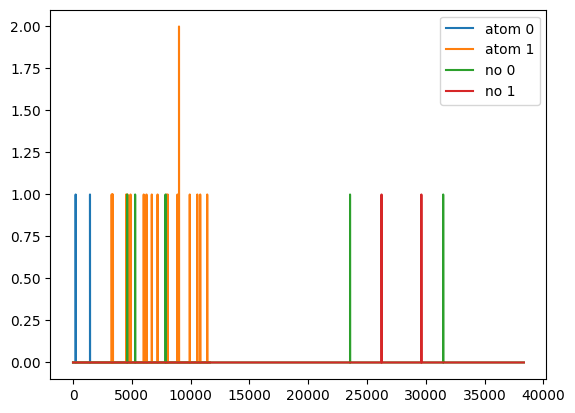

11649

In [30]:
# 1 iteration = n_measurement * n_excitation_cycle = 50,000
# plotting the last iteration; which is gate_start_offset_mu = 795. 


plt.plot(photon_counts_with_atom, label='atom 0')
plt.plot(photon_counts1_with_atom, label='atom 1')

plt.plot(photon_counts_no_atom, label='no 0')
plt.plot(photon_counts1_no_atom, label='no 1')
plt.legend()
plt.show()


filter_atom = readout_iteration_i > cutoff1
filter_atom

count_true = np.sum(filter_atom)
count_true

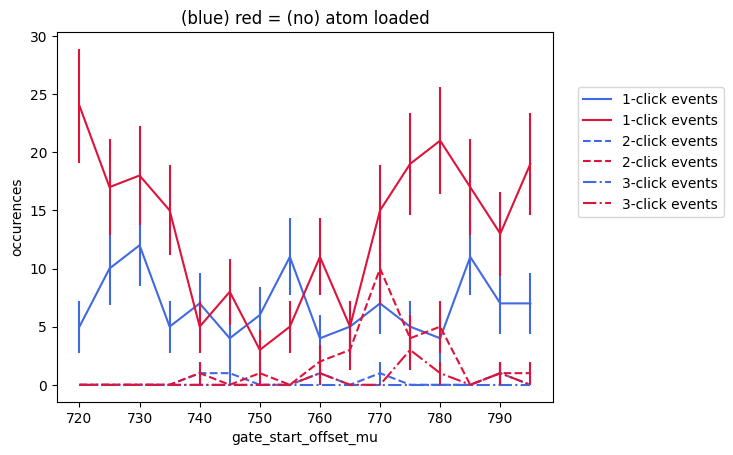

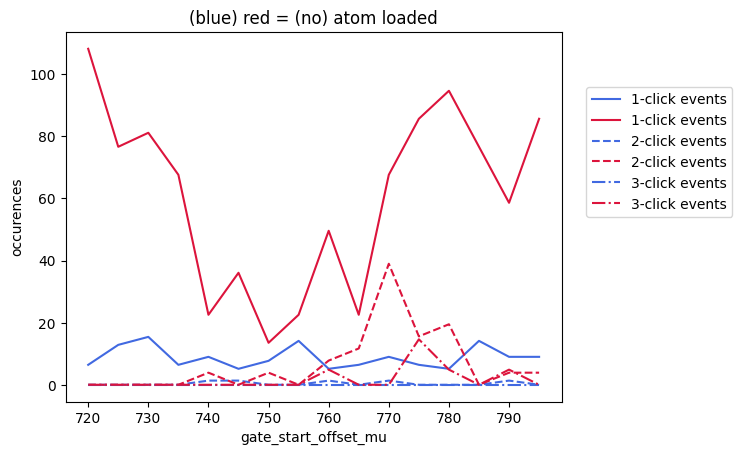

50000

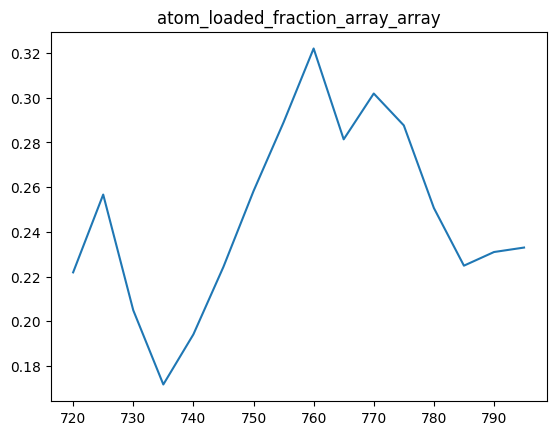

In [111]:
## total counts from SPCM0 + SPCM1 
## Plot using histogram

counts_data_no_atom = np.array(binned_data_no_atom).transpose()[1:]
counts_data_with_atom = np.array(binned_data_with_atom).transpose()[1:]

linestyles = ['-','--','-.']
for i in range(max(bins)-1):
    plt.plot(scan_sequence1, counts_data_no_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
    plt.plot(scan_sequence1, counts_data_with_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
    plt.errorbar(scan_sequence1, counts_data_no_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_no_atom[i]], ls='none',color='royalblue')
    plt.errorbar(scan_sequence1, counts_data_with_atom[i], yerr=[np.sqrt(x) if x > 0 else np.inf for x in counts_data_with_atom[i]], ls='none',color='crimson')
plt.legend(loc=(1.05,0.5))
plt.title('(blue) red = (no) atom loaded')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)

plt.show()

# atom_loaded fraction taken into account.
counts_data_with_atom_norm = [x / y for x, y in zip(counts_data_with_atom, atom_loaded_fraction_array)]
counts_data_no_atom_norm = [x / (1-y) for x, y in zip(counts_data_no_atom, atom_loaded_fraction_array)]


linestyles = ['-','--','-.']
for i in range(max(bins)-1):
    plt.plot(scan_sequence1, counts_data_no_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
    plt.plot(scan_sequence1, counts_data_with_atom_norm[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
plt.legend(loc=(1.05,0.5))
plt.title('(blue) red = (no) atom loaded')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)
plt.show()


# plt.plot(atom_loaded_fraction_array)
# plt.title("atom_loaded_fraction_array")
# plt.show()

plt.plot(scan_sequence1,atom_loaded_fraction_array)
plt.title("atom_loaded_fraction_array_array")

n_measurements*n_excitation_cycles

Assuming we only have click 0 or 1


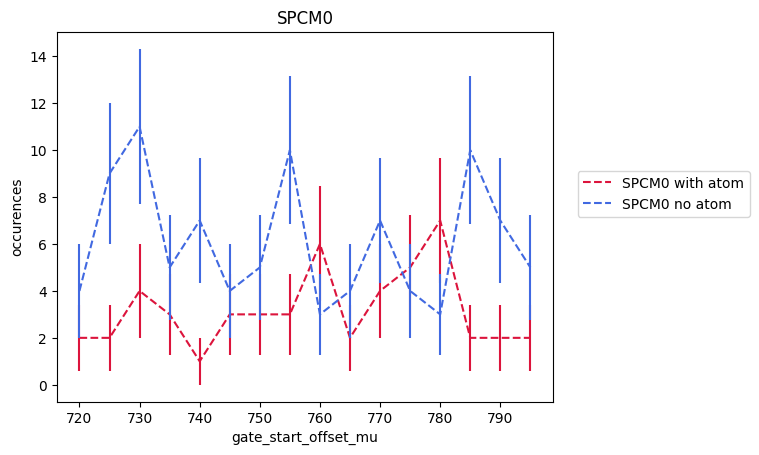

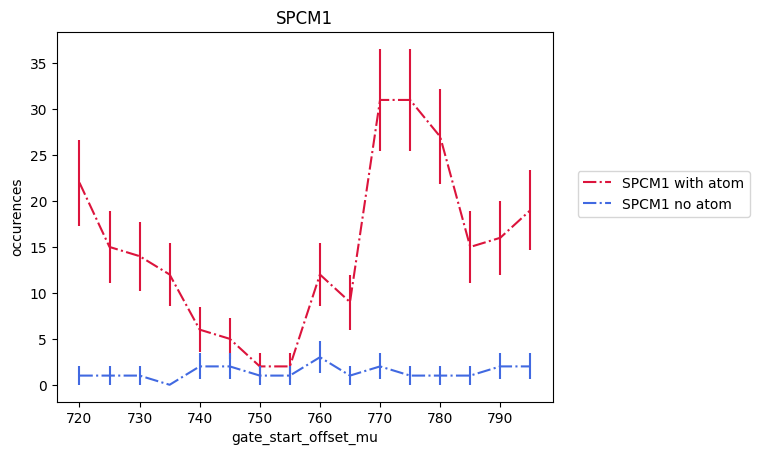

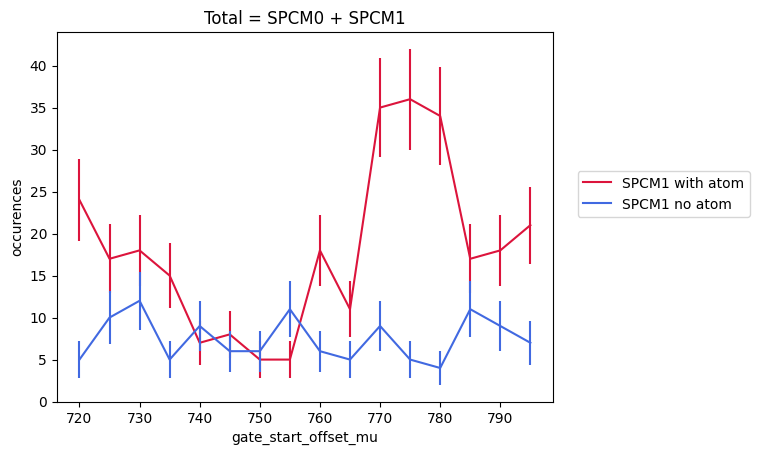

[2. 2. 4. 3. 1. 3. 3. 3. 6. 2. 4. 5. 7. 2. 2. 2.]
[22. 15. 14. 12.  6.  5.  2.  2. 12.  9. 31. 31. 27. 15. 16. 19.]
[24.0, 17.0, 18.0, 15.0, 7.0, 8.0, 5.0, 5.0, 18.0, 11.0, 35.0, 36.0, 34.0, 17.0, 18.0, 21.0]


In [105]:
####################????????????????????????????????????????????????????????????????
# manually counting


print("Assuming we only have click 0 or 1")

linestyles = ['--','-.', '-']
plt.plot(scan_sequence1, n_SPCM0_atom,label="SPCM0 with atom",ls=linestyles[0],color='crimson')
plt.plot(scan_sequence1, n_SPCM0_no_atom,label="SPCM0 no atom",ls=linestyles[0],color='royalblue')
plt.errorbar(scan_sequence1, n_SPCM0_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in n_SPCM0_atom], ls='none',color='crimson')
plt.errorbar(scan_sequence1, n_SPCM0_no_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in n_SPCM0_no_atom], ls='none',color='royalblue')
plt.legend(loc=(1.05,0.5))
plt.title('SPCM0')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)
plt.show()


plt.plot(scan_sequence1, n_SPCM1_atom,label="SPCM1 with atom",ls=linestyles[1],color='crimson')
plt.plot(scan_sequence1, n_SPCM1_no_atom,label="SPCM1 no atom",ls=linestyles[1],color='royalblue')
plt.errorbar(scan_sequence1, n_SPCM1_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in n_SPCM1_atom], ls='none',color='crimson')
plt.errorbar(scan_sequence1, n_SPCM1_no_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in n_SPCM1_no_atom], ls='none',color='royalblue')
plt.legend(loc=(1.05,0.5))
plt.title('SPCM1')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)
plt.show()

total_count_atom = [x + y for x, y in zip(n_SPCM0_atom, n_SPCM1_atom)]
total_count_no_atom = [x + y for x, y in zip(n_SPCM0_no_atom, n_SPCM1_no_atom)]


plt.plot(scan_sequence1, total_count_atom,label="SPCM1 with atom",ls=linestyles[2],color='crimson')
plt.plot(scan_sequence1, total_count_no_atom,label="SPCM1 no atom",ls=linestyles[2],color='royalblue')
plt.errorbar(scan_sequence1, total_count_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in total_count_atom], ls='none',color='crimson')
plt.errorbar(scan_sequence1, total_count_no_atom, yerr=[np.sqrt(x) if x > 0 else np.inf for x in total_count_no_atom], ls='none',color='royalblue')
plt.legend(loc=(1.05,0.5))
plt.title('Total = SPCM0 + SPCM1')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)
plt.show()

print(n_SPCM0_atom)
print(n_SPCM1_atom)
print(total_count_atom)

# 2024.12.25

In [94]:
fnames = get_files_by_criteria(date_filters=["2024-12-24", "2024-12-25"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 37 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020830-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020830-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020831-GeneralVariableScan.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020833-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020834-GeneralVariableScan.h5) scanned over dummy_variable
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\10\000020835-GeneralVariableScan.h5) scanned over dummy_variable
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\10\000020836-Gene

## test code

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'record_every_shot': True,'n_excitation_cycles': 200, 'gate_start_offset_mu': 720}
# of iterations:  5


C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\QC\.virtualenvs\Networking_Exp_Data-0oRq_J3c\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


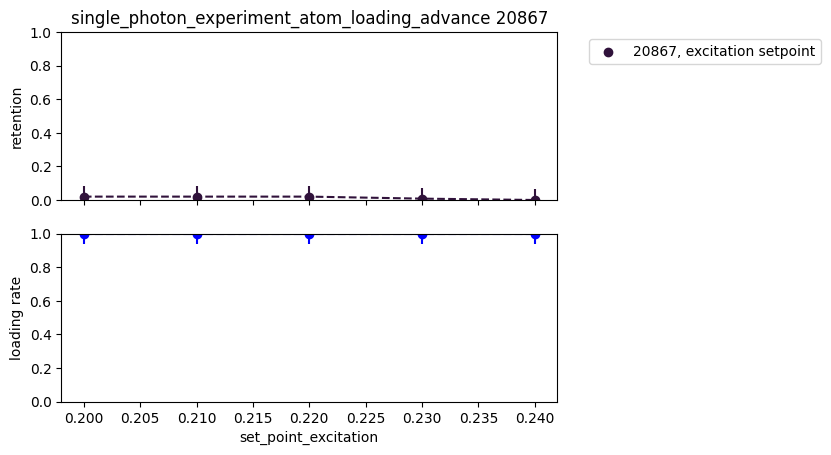

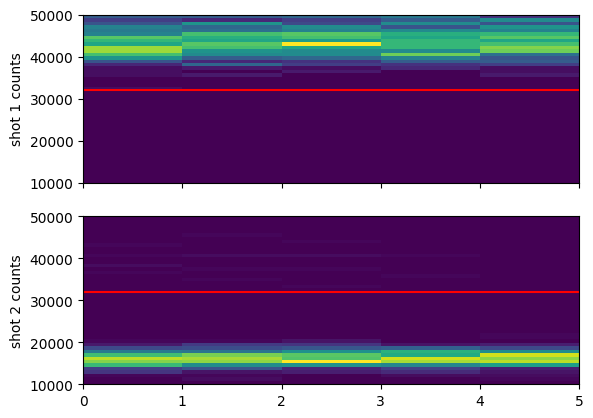

In [101]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = False


file_indices = {
    # 34: 'excitation setpoint - D1 unlocked at some point',
    36: 'excitation setpoint'
} # the files to plot; 


# for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    # get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


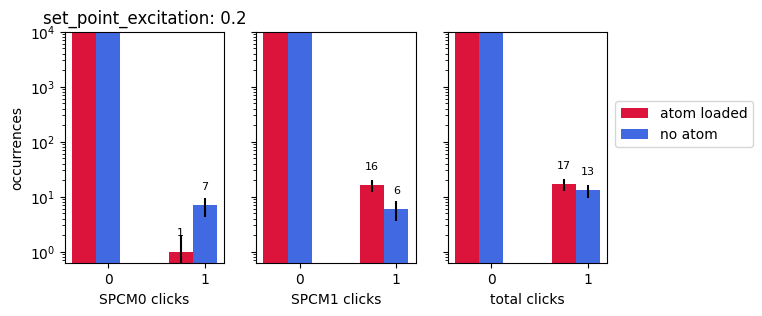

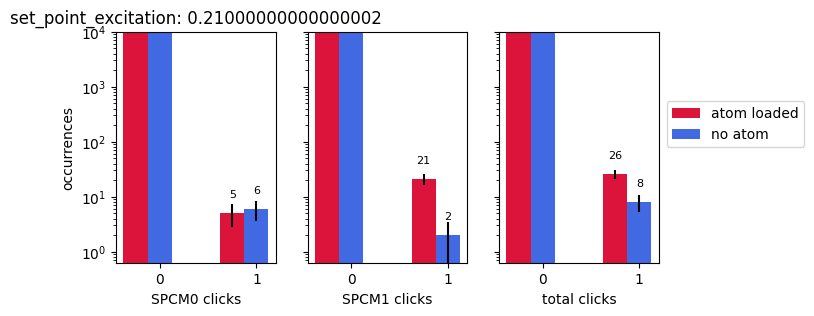

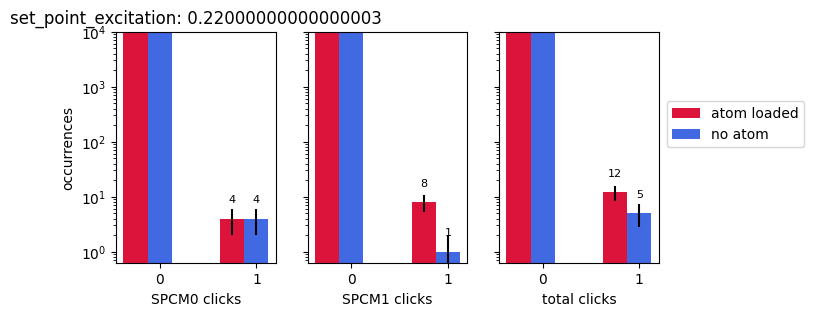

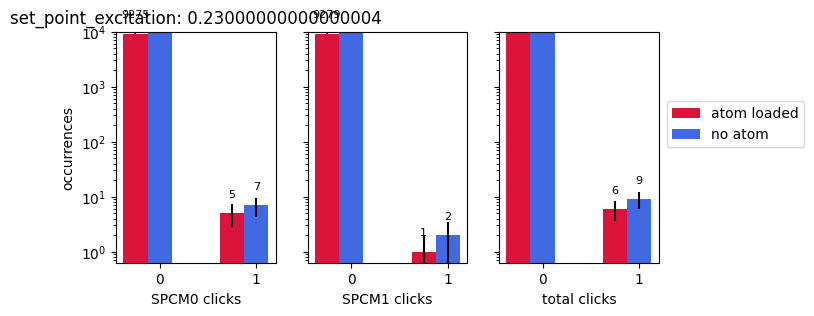

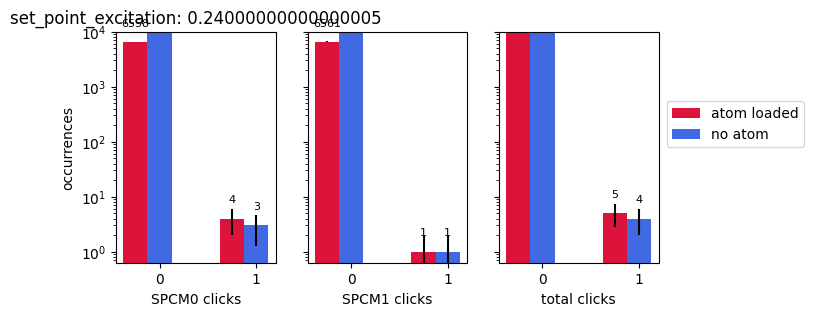

In [102]:
# todo: do not plot bin 0

max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]
units = 1e-9
unit_label = 'ns'

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

for i, var_value in zip(range(iterations),scan_sequence1):

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars


    # iteration
    # photons are counted from SPCMs 0 and 1 for the excitation phase
    photons_iteration_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    photons1_iteration_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_iteration_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]

    # iteration => n_measurements => n_excitation_cycle
    
    # # first_shot
    # shot1 = photocounts[i*n_measurements:(i+1)*n_measurements] # only from SPCM 0

    # SPCM0
    photon_counts_with_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts_no_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()
    
    # SPCM1
    photon_counts1_with_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts1_no_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()

    total_photon_counts_with_atom = np.concatenate((photon_counts_with_atom, photon_counts1_with_atom))
    total_photon_counts_no_atom = np.concatenate((photon_counts_no_atom, photon_counts1_no_atom))

    # # Ex) False count 
    # if i == 15:
    #     plt.plot(photon_counts_with_atom, label = "SPCM0 with atom")
    #     # plt.plot(photon_counts_no_atom, label = "SPCM0 no atom")

    #     plt.plot(photon_counts1_with_atom, label = "SPCM1 with atom")
    #     # plt.plot(photon_counts1_no_atom, label = "SPCM1 no atom")
    #     plt.title("i == 15")
    #     plt.legend()
    

    ##### filtering counts using first shot.
    # this is by iteration => change this to => every cycle
    


    # if i == 10:
    #     print(mean_photons_per_cycle_with_atom)
    #     for j, val1, val2 in zip(range(len(mean_photons_per_cycle_with_atom)), mean_photons_per_cycle_with_atom, mean_photons1_per_cycle_with_atom):
    #         if val1 > 0 or val2 >0:
    #             print(j, val1, val2)
    #     print(total_photon_counts_with_atom)
    #     for j, val in zip(range(len(total_photon_counts_with_atom)), total_photon_counts_with_atom):
    #         if val > 0:
    #             print(j, val)
    # iterate over the data from the two SPCMs so we can fill in a subplot for each one


    fig,axes = plt.subplots(ncols=3,figsize=(7,3),sharey=True)

    # iterate over the data from the two SPCMs so we can fill in a subplot for each one
    data_idx = 0
    for ax, data_atom, data_no_atom in zip(axes,[photon_counts_with_atom, photon_counts1_with_atom, total_photon_counts_with_atom],
                                           [photon_counts_no_atom, photon_counts1_no_atom, total_photon_counts_no_atom]):
        atom = 1
        multiplier = 0 # moves the bar offset so that atom/no atom bars aren't overlapping
        for data, label, color in zip([data_atom, data_no_atom],barlegend,colors):
            offset = width * multiplier
            binned_data = np.histogram(data, bins=bins)[0]
            rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
            ax.bar_label(rects, padding=10, fontsize=8)
            ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
            multiplier += 1

            # append the data for both SPCMs with/out an atom
            if data_idx==2:
                if atom: 
                    binned_data_with_atom.append(binned_data)
                if not atom: 
                    binned_data_no_atom.append(binned_data)
            atom -= 1
        data_idx += 1
            
    axes[0].set_ylabel('occurrences')

    for ax_n, ax in enumerate(axes):
        ax.set_yscale('log')
        ax.set_xticks(x + width, x)
        ax.set_ylim((10**(-0.2),1e4))
        ax.set_xlabel(f'SPCM{ax_n} clicks')
    axes[2].set_xlabel('total clicks')
    axes[-1].legend(loc=(1.05,0.5))

    if use_titles:
        axes[0].set_title(titles[i])
    else:
        try:
            axes[0].set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
        except TypeError: # probably a string
            axes[0].set_title(str(var_value)[2:-1])

        
        
    # ax.legend(loc='upper left', ncols=3)

    # fig.tight_layout()
plt.show()


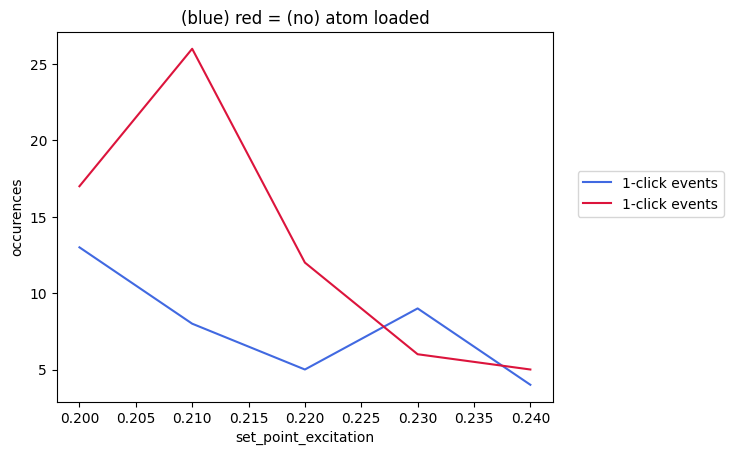

In [103]:
counts_data_no_atom = np.array(binned_data_no_atom).transpose()[1:]
counts_data_with_atom = np.array(binned_data_with_atom).transpose()[1:]

thresh = cutoff1

linestyles = ['-','--','-.']
for i in range(max(bins)-1):
    plt.plot(scan_sequence1, counts_data_no_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='royalblue')
    plt.plot(scan_sequence1, counts_data_with_atom[i],label=f'{i+1}-click events',ls=linestyles[i],color='crimson')
plt.legend(loc=(1.05,0.5))
plt.title('(blue) red = (no) atom loaded')
plt.ylabel('occurences')
plt.xlabel(scan_variable1_name)
plt.show()


# 2024.12.25

In [9]:
fnames = get_files_by_criteria(date_filters=["2024-12-24", "2024-12-25"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-25\11\000020868-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_set_point_excitation.h5, which is corrupt
found 41 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020830-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020830-GeneralVariableScan_single_photon_scan_over_dummy_variable.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020831-GeneralVariableScan.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020833-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-24\09\000020834-GeneralVariableScan.h5) scanned over dummy_variable
file 5 (C:\Networking Experiment\artiq

## gate_start_offset - n_measurement = 100; somehow it just set to this itself

experiment: single_photon_experiment_atom_loading_advance
override: {'dummy_variable':4,'require_atom_loading_to_advance_in_single_photon_exp': True, 'record_every_shot': True,'n_excitation_cycles': 200, 'set_point_excitation': 0.055}
# of iterations:  24
iteration 21, no measurements


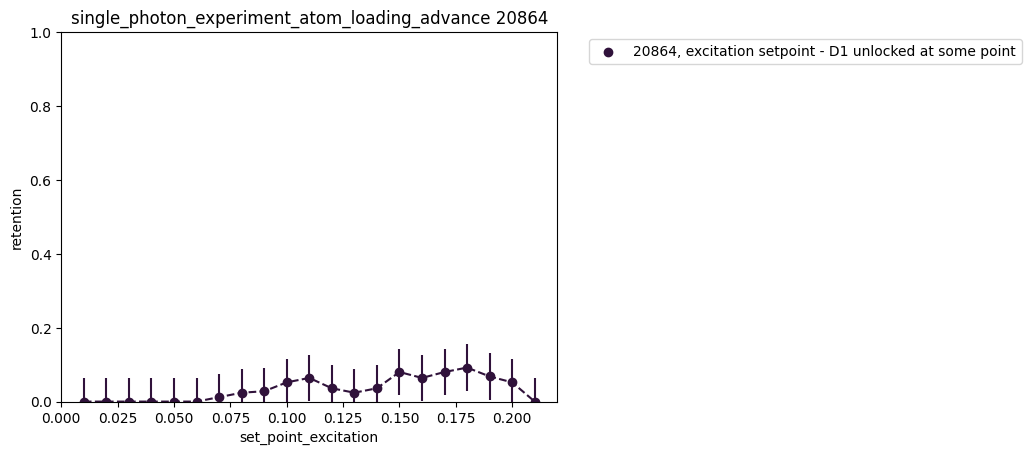

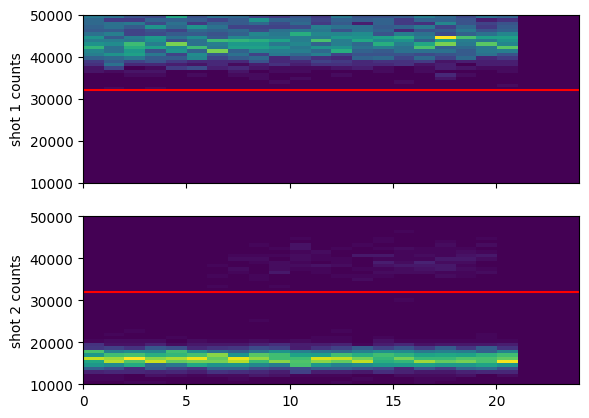

In [12]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = False

show_photocount_hist = False 
calculate_g2 = True


file_indices = {
   # 40: 'gate_start_offset'
    34: 'excitation setpoint - D1 unlocked at some point',
} # the files to plot; 


# for plotting
legend_vars =[]  # legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

# for fitting
fit_dict = {}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''


for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    print("# of iterations: ", iterations)
    
    if otsu_threshold:
        thresh = threshold_otsu(photocounts)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_counts_per_s * t_SPCM_first_shot

    
    # for plotting 
    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    # get_loading_and_retention
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' which is Fortran-style order
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    # show historam of first_shot and second_shot
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

# AZ_bottom_volts_MOT, AZ_top_volts_MOT, AX_volts_MOT, AY_volts_MOT


In [13]:
# todo: do not plot bin 0

max_counts = max(excitation_counts)+1
bins = list(np.array(list(range(max_counts+1))))  #[0,1,...,max_counts+1]
units = 1e-9
unit_label = 'ns'

titles = [f"{scan_variable1_name}: {val}" for val in scan_sequence1]
use_titles = True

binned_data_with_atom = []
binned_data_no_atom = []

atom_loaded_counts_array = np.zeros(iterations)
atom_loaded_fraction_array = np.zeros(iterations)

for i, var_value in zip(range(iterations),scan_sequence1):

    xlabels = [str(x) for x in range(max_counts)]
    barlegend = ["atom loaded","no atom"]
    colors = ['crimson','royalblue']
    x = np.arange(len(xlabels))  # the label locations
    width = 0.25  # the width of the bars


    # iteration
    # photons are counted from SPCMs 0 and 1 for the excitation phase
    photons_iteration_i = excitation_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    photons1_iteration_i = excitation_counts1[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]
    readout_iteration_i = readout_counts[1:][n_measurements*n_excitation_cycles*i:(n_measurements*n_excitation_cycles)*(i+1)]

    # iteration => n_measurements => n_excitation_cycle
    
    # # first_shot
    # shot1 = photocounts[i*n_measurements:(i+1)*n_measurements] # only from SPCM 0
    
    
    # SPCM0
    photon_counts_with_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts_no_atom = np.array([p for p,s in zip(photons_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()
    
    # SPCM1
    photon_counts1_with_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s > cutoff1]).flatten()
    photon_counts1_no_atom = np.array([p for p,s in zip(photons1_iteration_i, readout_iteration_i) if s <= cutoff1]).flatten()

    total_photon_counts_with_atom = np.concatenate((photon_counts_with_atom, photon_counts1_with_atom))
    total_photon_counts_no_atom = np.concatenate((photon_counts_no_atom, photon_counts1_no_atom))

    # # Ex) False count 
    # if i == 15:
    #     plt.plot(photon_counts_with_atom, label = "SPCM0 with atom")
    #     # plt.plot(photon_counts_no_atom, label = "SPCM0 no atom")

    #     plt.plot(photon_counts1_with_atom, label = "SPCM1 with atom")
    #     # plt.plot(photon_counts1_no_atom, label = "SPCM1 no atom")
    #     plt.title("i == 15")
    #     plt.legend()
    

    ##### filtering counts using first shot.
    # this is by iteration => change this to => every cycle

    # for normalization
    atom_loaded_counts = 0
    for val in readout_iteration_i:
        if val > cutoff1:
            atom_loaded_counts += 1

    atom_loaded_counts_array[i] = atom_loaded_counts
    if len(readout_iteration_i) > 0:
        atom_loaded_fraction_array[i] = atom_loaded_counts / len(readout_iteration_i)


    

    
    if calculate_g2:
        ### g2 calculation
        # counting count_atom_case & count_no_atom_case - this does the same thing as above - atom_loaded_counts
        count_atom_case = 0
    
        filter_atom = readout_iteration_i > cutoff1
        
        count_atom_case = np.sum(filter_atom)
        count_no_atom_case = len(readout_iteration_i) - count_atom_case
        print(f"{scan_variable1_name} = {var_value} ")
        print(f"count_atom_case {count_atom_case}, count_no_atom_case {count_no_atom_case}, total {len(readout_iteration_i)}")
    
        # atom case
        n_SPCM0_atom[i] = np.sum(photon_counts_with_atom)
        n_SPCM1_atom[i] = np.sum(photon_counts1_with_atom)
        # n_co_atom[i] = np.sum(np.array([p for p,s in zip(photon_counts_with_atom, photon_counts1_with_atom) if (p>0 and s>0)]).flatten())
        n_co_atom[i] = 0
        
        for val1, val2 in zip(photon_counts_with_atom, photon_counts1_with_atom):
                if val1 > 0 and val2 >0:
                    n_co_atom[i] += 1
        
        
        # no atom case
        n_SPCM0_no_atom[i] = np.sum(photon_counts_no_atom)
        n_SPCM1_no_atom[i] = np.sum(photon_counts1_no_atom)
        # n_co_no_atom[i] = np.sum(np.array([p for p,s in zip(photon_counts_no_atom, photon_counts1_no_atom) if (p>0 and s>0)]).flatten())
        n_co_no_atom[i] = 0
        for val1, val2 in zip(photon_counts_no_atom, photon_counts1_no_atom):
            if val1 > 0 and val2 >0:
                n_co_no_atom[i] += 1
        
        g2_atom[i] = n_co_atom[i]/n_SPCM0_atom[i]/n_SPCM1_atom[i]*count_atom_case
        g2_no_atom[i] = n_co_no_atom[i]/n_SPCM0_no_atom[i]/n_SPCM1_no_atom[i]*count_no_atom_case
    
        print(f"atom case: n_co_atom[i] {n_co_atom[i]}, n_SPCM0_atom[i] {n_SPCM0_atom[i]}, n_SPCM1_atom[i] {(n_SPCM1_atom[i])}")
        print(f"no atom case: n_co_no_atom[i] {n_co_no_atom[i]}, n_SPCM0_no_atom[i] {n_SPCM0_no_atom[i]}, n_SPCM1_no_atom[i] {(n_SPCM1_no_atom[i])}")
        
        print(f"g2_atom[i] = {g2_atom[i]}")
        print(f"g2_no_atom[i] = {g2_no_atom[i]}")
        print("")

    # if i == 10:
    #     print(mean_photons_per_cycle_with_atom)
    #     for j, val1, val2 in zip(range(len(mean_photons_per_cycle_with_atom)), mean_photons_per_cycle_with_atom, mean_photons1_per_cycle_with_atom):
    #         if val1 > 0 or val2 >0:
    #             print(j, val1, val2)
    #     print(total_photon_counts_with_atom)
    #     for j, val in zip(range(len(total_photon_counts_with_atom)), total_photon_counts_with_atom):
    #         if val > 0:
    #             print(j, val)
    # iterate over the data from the two SPCMs so we can fill in a subplot for each one

    if show_photocount_hist:
        fig,axes = plt.subplots(ncols=3,figsize=(7,3),sharey=True)


    # iterate over the data from the two SPCMs so we can fill in a subplot for each one
    data_idx = 0
    for ax, data_atom, data_no_atom in zip(axes,[photon_counts_with_atom, photon_counts1_with_atom, total_photon_counts_with_atom],
                                           [photon_counts_no_atom, photon_counts1_no_atom, total_photon_counts_no_atom]):
        atom = 1
        multiplier = 0 # moves the bar offset so that atom/no atom bars aren't overlapping
        for data, label, color in zip([data_atom, data_no_atom],barlegend,colors):
            offset = width * multiplier
            binned_data = np.histogram(data, bins=bins)[0]
            if show_photocount_hist:
                rects = ax.bar(x + offset, binned_data, width, label=label, color=color)
                ax.bar_label(rects, padding=10, fontsize=8)
                ax.errorbar(x + offset, binned_data, yerr=np.sqrt(binned_data), color='k', ls='none')
            multiplier += 1

            # append the data for both SPCMs with/out an atom
            if data_idx==2:
                if atom: 
                    binned_data_with_atom.append(binned_data)
                if not atom: 
                    binned_data_no_atom.append(binned_data)
            atom -= 1
        data_idx += 1
        
    if show_photocount_hist:
        axes[0].set_ylabel('occurrences')
    
        for ax_n, ax in enumerate(axes):
            ax.set_yscale('log')
            ax.set_xticks(x + width, x)
            ax.set_ylim((10**(-0.2),1e4))
            ax.set_xlabel(f'SPCM{ax_n} clicks')
        axes[2].set_xlabel('total clicks')
        axes[-1].legend(loc=(1.05,0.5))
    
        if use_titles:
            axes[0].set_title(titles[i])
        else:
            try:
                axes[0].set_title(f"{scan_variable1_name} = {var_value/units:.2f} "+unit_label)
            except TypeError: # probably a string
                axes[0].set_title(str(var_value)[2:-1])

        
        
    # ax.legend(loc='upper left', ncols=3)

    # fig.tight_layout()
# plt.show()



set_point_excitation = 0.01 
count_atom_case 5972, count_no_atom_case 44028, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 1, n_SPCM2_atom 0
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 6, n_SPCM2_no_atom 0
g2_atom = nan
g2_no_atom = nan

set_point_excitation = 0.02 
count_atom_case 7394, count_no_atom_case 42606, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 1, n_SPCM2_atom 0
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 3, n_SPCM2_no_atom 2
g2_atom = nan
g2_no_atom = 0.0

set_point_excitation = 0.03 
count_atom_case 7057, count_no_atom_case 42943, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 0, n_SPCM2_atom 1
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 4, n_SPCM2_no_atom 2
g2_atom = nan
g2_no_atom = 0.0



C:\Users\QC\AppData\Local\Temp\ipykernel_336\619194627.py:109: RuntimeWarning: invalid value encountered in scalar divide
  g2_atom = n_co_atom/n_SPCM1_atom/n_SPCM2_atom*count_atom_case
C:\Users\QC\AppData\Local\Temp\ipykernel_336\619194627.py:110: RuntimeWarning: invalid value encountered in scalar divide
  g2_no_atom = n_co_no_atom/n_SPCM1_no_atom/n_SPCM2_no_atom*count_no_atom_case


set_point_excitation = 0.04 
count_atom_case 6838, count_no_atom_case 43162, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 2, n_SPCM2_atom 0
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 5, n_SPCM2_no_atom 1
g2_atom = nan
g2_no_atom = 0.0

set_point_excitation = 0.05 
count_atom_case 7978, count_no_atom_case 42022, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 2, n_SPCM2_atom 0
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 9, n_SPCM2_no_atom 3
g2_atom = nan
g2_no_atom = 0.0

set_point_excitation = 0.060000000000000005 
count_atom_case 9071, count_no_atom_case 40929, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 2, n_SPCM2_atom 0
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 5, n_SPCM2_no_atom 1
g2_atom = nan
g2_no_atom = 0.0

set_point_excitation = 0.06999999999999999 
count_atom_case 9822, count_no_atom_case 40178, total 50000
atom case: n_co_atom 0, n_SPCM1_atom 5, n_SPCM2_atom 1
no atom case: n_co_no_atom 0, n_SPCM1_no_atom 5, n_SPCM2_no_atom 0
g2_atom = 0.0
g2_no_atom = na